# MASTER - Notebook 1 - Only temporal Cleaning
### Matteo Grazioso 884055

In [166]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
warnings.filterwarnings('ignore')

import myfunctions as mf # Custom functions

In [167]:
# Disply all columns and all rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [168]:
# Find all txt files in the data folder
txt_files = mf.find_txt_files("data/raw")

# Choose a dataset from the list of txt files
selected_dataset = mf.choose_dataset(txt_files)

if selected_dataset:
    print(f"You selected the dataset {selected_dataset}")
else:
    print("No dataset selected.")

path  = selected_dataset

The following files were found:
1. data/raw/0-export.txt
2. data/raw/1-validazioni.txt
3. data/raw/2-esportazioneCompleta.txt
4. data/raw/3-esportazionePasqua23.txt
5. data/raw/4-esportazioneFineAgosto2023.txt
6. data/raw/restricted_2023-01-17_2023-02-03_2-esportazioneCompleta.txt
7. data/raw/restricted_2023-02-04_2023-02-21_2-esportazioneCompleta.txt
8. data/raw/restricted_2023-02-22_2023-03-12_2-esportazioneCompleta.txt
You selected the dataset data/raw/4-esportazioneFineAgosto2023.txt


In [169]:
# The file contain the data of the validation of tickets in the city of public transport of Venice.

# Import the data into a dataframe of a txt file 
# path = 'data/raw/1-validazioni.txt'                     # Period: 2022-05-13 to 2022-07-15
# path = 'data/raw/2-esportazioneCompleta.txt'            # Period: 2023-01-23 to 2023-03-14
# path = 'data/raw/3-esportazionePasqua23.txt'            # Period: 2023-04-04 to 2023-06-03

df = pd.read_csv(path, header=0, sep='\t')
# Save the name of the file in a variable for future use extracting the name of the file from the path
file_name = path.split('/')[-1].split('.')[0]
# Remove the number and the - character from the head of the file name
file_name = file_name [file_name.find('-')+1:]


In [170]:
file_name

'esportazioneFineAgosto2023'

In [171]:
# Open all file in txt_files and print the number of rows
for file in txt_files:
    with open(file, 'r') as f:
        print(f"File: {file.split('/')[-1]} - Number of rows: {len(f.readlines())}")

File: 0-export.txt - Number of rows: 4876779
File: 1-validazioni.txt - Number of rows: 5056642
File: 2-esportazioneCompleta.txt - Number of rows: 5537467
File: 3-esportazionePasqua23.txt - Number of rows: 8644448
File: 4-esportazioneFineAgosto2023.txt - Number of rows: 8897365
File: restricted_2023-01-17_2023-02-03_2-esportazioneCompleta.txt - Number of rows: 1337680
File: restricted_2023-02-04_2023-02-21_2-esportazioneCompleta.txt - Number of rows: 1948518
File: restricted_2023-02-22_2023-03-12_2-esportazioneCompleta.txt - Number of rows: 1796680


In [172]:
# Check the first 5 rows of the data
df.head()

,DATA_VALIDAZIONE,SERIALE,FERMATA,DESCRIZIONE,TITOLO,DESCRIZIONE_TITOLO
0,21/08/2023 00:00,65694327771460101,5039,"Rialto ""C""",11261,"DailyP-Tpl19,71-C.Ve5,29"
1,21/08/2023 00:00,65693985567963653,510,VENEZIA,12101,Bigl.Aut.75'Mestre/Lido-tsc
2,21/08/2023 00:00,-3604499471,5001,Lido S.M.E.,23101,Mensile ordinario Rete Unica
3,21/08/2023 00:00,-2863236226,5031,"P.le Roma ""G",9001,Libera circ. RETE intera
4,21/08/2023 00:00,40555998074596612,5089,"Ferrovia ""D""",11101,"75'-Tpl 7,47-ComVe2,03"


In [173]:
# Check the last 5 rows of the data
df.tail()

,DATA_VALIDAZIONE,SERIALE,FERMATA,DESCRIZIONE,TITOLO,DESCRIZIONE_TITOLO
8897359,20/10/2023 23:59,41681425265123588,5013,S. Marco-San,11108,"72h-Tpl 35,36-ComVe9,64"
8897360,20/10/2023 23:59,65694392951470085,5013,S. Marco-San,11109,"72h Roll.Ven-Tpl21,22-C.Ve5,78"
8897361,20/10/2023 23:59,-2854847547,5013,S. Marco-San,11209,Bigl RETE UNICA 75'
8897362,20/10/2023 23:59,-2821804860,5013,S. Marco-San,20003,Mensile ORDINARIO ISOLE
8897363,20/10/2023 23:59,41681897975183364,5024,"Tronchetto """,11101,"75'-Tpl 7,47-ComVe2,03"


In [174]:
# Create a subset of the data with the first 10% of the rows and the last 10% of the rows
# df = df.iloc[:int(len(df)*0.01),:]
# df = df.append(df.iloc[-int(len(df)*0.1):,:])


## Explorative Data Analysis


In [175]:
# Dates and hour of the validation of the ticket are in the same column 'DATA_VALIDAZIONE'
# Split the column 'DATA_VALIDAZIONE' into two columns 'DATA' and 'ORA' and convert them to datetime format
df.insert(0, 'DATA', pd.to_datetime(df['DATA_VALIDAZIONE'].str.split(' ').str[0], format='%d/%m/%Y'))
df.insert(1, 'ORA', pd.to_datetime(df['DATA_VALIDAZIONE'].str.split(' ').str[1], format='%H:%M').dt.time)

# Drop the column 'DATA_VALIDAZIONE'
# df.drop('DATA_VALIDAZIONE', axis=1, inplace=True)

# Display the first 5 rows of the dataframe
df.head()

,DATA,ORA,DATA_VALIDAZIONE,SERIALE,FERMATA,DESCRIZIONE,TITOLO,DESCRIZIONE_TITOLO
0,2023-08-21,00:00:00,21/08/2023 00:00,65694327771460101,5039,"Rialto ""C""",11261,"DailyP-Tpl19,71-C.Ve5,29"
1,2023-08-21,00:00:00,21/08/2023 00:00,65693985567963653,510,VENEZIA,12101,Bigl.Aut.75'Mestre/Lido-tsc
2,2023-08-21,00:00:00,21/08/2023 00:00,-3604499471,5001,Lido S.M.E.,23101,Mensile ordinario Rete Unica
3,2023-08-21,00:00:00,21/08/2023 00:00,-2863236226,5031,"P.le Roma ""G",9001,Libera circ. RETE intera
4,2023-08-21,00:00:00,21/08/2023 00:00,40555998074596612,5089,"Ferrovia ""D""",11101,"75'-Tpl 7,47-ComVe2,03"


In [176]:
# Set the format of the timestamp
df['DATA_VALIDAZIONE'] = pd.to_datetime(df['DATA_VALIDAZIONE'], format='%d/%m/%Y %H:%M')

In [177]:
# Print the date of the first and last validation using both data and hour
print('First validation: ', df['DATA'].min(), df['ORA'].min())
print('Last validation: ', df['DATA'].max(), df['ORA'].max())

# Print the number of Serial numbers
print('Number of Serial numbers: ', df_1['SERIALE'].nunique())

# Print the number of validation (rows)
print('Number of validation: ', df.shape[0])

# Print the number of tickets
print('Number of tickets: ', df['DESCRIZIONE_TITOLO'].nunique())
# Print the number of titolo
print('Number of titolo: ', df['TITOLO'].nunique())

# Print the number of FERMATA
print('Number of FERMATA: ', df['FERMATA'].nunique())
# Print the number of DESCRIZIONE
print('Number of DESCRIZIONE: ', df['DESCRIZIONE'].nunique())

First validation:  2023-08-21 00:00:00 00:00:00
Last validation:  2023-10-20 00:00:00 23:59:00
Number of Serial numbers:  1237025
Number of validation:  8897364
Number of tickets:  343
Number of titolo:  343
Number of FERMATA:  1900
Number of DESCRIZIONE:  1028


In [178]:
# Which is the most used ticket?
df['DESCRIZIONE_TITOLO'].value_counts().head(10)

DESCRIZIONE_TITOLO
Bigl RETE UNICA 75'             1430722
DailyP-Tpl19,71-C.Ve5,29        1088800
Mensile ordinario Rete Unica    1007284
75'-Tpl 7,47-ComVe2,03           922939
48h-Tpl 27,50-ComVe7,50          607447
Bigl.Aut.75'Mestre/Lido-tsc      485761
72h-Tpl 35,36-ComVe9,64          451060
Annuale ordinario Rete Unica     367093
7gg-Tpl 51,08-ComVe13,92         311183
Mens.Studente Rete Unica         156623
Name: count, dtype: int64

In [179]:
# Which is the most frequent validation in date and hour?
# Date and hour are in two different columns; DATA_VALIDAZIONE does not exist anymore
df.groupby(['DATA', 'ORA'])['SERIALE'].count().sort_values(ascending=False).head(10)
# TODO: #4 Re-aswer the question of the most frequent validation after cleaning operations

DATA        ORA     
2023-08-30  03:44:00    1113
2023-08-31  03:44:00     685
2023-08-29  12:04:00     667
2023-08-30  03:17:00     429
2023-08-31  03:17:00     379
2023-09-09  17:25:00     361
2023-10-07  10:27:00     344
2023-10-01  16:28:00     339
2023-09-15  11:27:00     337
2023-09-08  10:10:00     336
Name: SERIALE, dtype: int64

In [180]:
# Which is the most frequent FERMATA?
df['DESCRIZIONE'].value_counts().head(10)

DESCRIZIONE
Lido S.M.E.     745025
S. Marco-San    517439
P.le Roma "G    498120
Rialto "C"      410212
VENEZIA         363717
San Marco-Sa    304860
Burano "C"      299114
P.le Roma "E    292110
Ferrovia "B"    273193
Punta Sabbio    192254
Name: count, dtype: int64

## Categories

The column TICKET_CODE will be filled with the code of the ticket profile according to the ticket type and the ticket validity as follows:

**1.** One-day ticket

**2.** Two-day ticket

**3.** Three-day ticket

**4.** Weekly ticket (Seven-day ticket)

**5.** Monthly ticket

**5-STUD.** Monthly ticket for students

**5-RET.** Monthly ticket for retirees

**5-WKRS.** Monthly ticket for workers

**6.** Annual ticket

**6-STUD.** Annual ticket for students

**6-RET.** Annual ticket for retirees

**6-WKRS.** Annual ticket for workers

**7.** 75 minutes ticket

**8.** Other ticket (if it is necessary to add other types of tickets)

In [181]:
def assignTicketCode(df_a: pd.DataFrame):
    """
        This function assigns a ticket code to each row of the dataframe.
        :param df: the dataframe
        :return: the dataframe with the new column TICKET_CODE
    """
    # Add a new column with the code profile of the ticket
    df_a.insert(7, "TICKET_CODE", 'TBD')

    # Define the dictionary of ticket codes
    dict_tickets = {'1': 'One-day ticket', '2': 'Two-day ticket', '3': 'Three-day ticket', 
                '4': 'Seven-day ticket', 
                '5': 'Monthly ticket', '5-STUD': 'Monthly ticket for students',
                '5-RET': 'Monthly ticket for retired', '5-WKRS': 'Monthly ticket for workers',
                '6': 'Annual ticket', '6-STUD': 'Annual ticket for students', '6-RET': 'Annual ticket for retired',
                '6-WKRS': 'Annual ticket for workers',
                '7': '75 minutes ticket', '8': 'Other ticket'}
    
    # Convert the column 'DESCRIZIONE_TITOLO' into upper case 
    df_a['DESCRIZIONE_TITOLO'] = df_a['DESCRIZIONE_TITOLO'].str.upper()

    # One-day ticket
    df_a.loc[df_a['DESCRIZIONE_TITOLO'].str.contains('GIORNALIERO|24H|24ORE|24 ORE|DAILY'), 'TICKET_CODE'] = '1'
    # Two-day ticket
    df_a.loc[df_a['DESCRIZIONE_TITOLO'].str.contains('48H|48ORE|48 ORE'), 'TICKET_CODE'] = '2'
    # Three-day ticket
    df_a.loc[df_a['DESCRIZIONE_TITOLO'].str.contains('72H|72ORE|72 ORE'), 'TICKET_CODE'] = '3'
    # Seven-day ticket
    df.loc[df['DESCRIZIONE_TITOLO'].str.contains('7GG|7DAYS|7 DAYS'), 'TICKET_CODE'] = '4'    
    # Monthly ticket
    df_a.loc[df_a['DESCRIZIONE_TITOLO'].str.contains('MENSILE|30GG|30 GG|MENS'), 'TICKET_CODE'] = '5'
    ## Monthly ticket for students
    df_a.loc[(df_a['TICKET_CODE'] == '5') & (df_a['DESCRIZIONE_TITOLO'].str.contains('STUDENTE|STUD')), 'TICKET_CODE'] = '5-STUD'
    ## Monthly ticket for retired
    df_a.loc[(df_a['TICKET_CODE'] == '5') & (df_a['DESCRIZIONE_TITOLO'].str.contains('OVER 65|65+|PENSIONATI')), 'TICKET_CODE'] = '5-RET'
    ## Monthly ticket for workers
    df_a.loc[(df_a['TICKET_CODE'] == '5') & (df_a['DESCRIZIONE_TITOLO'].str.contains('LAVORATORE|LAV')), 'TICKET_CODE'] = '5-WKRS'
    ## DDRG 1201-1297/2022
    df_a.loc[df_a['DESCRIZIONE_TITOLO'].str.contains('DDGR1201-1297/2022'), 'TICKET_CODE'] = '5'
    # Yearly ticket
    df_a.loc[df_a['DESCRIZIONE_TITOLO'].str.contains('ANNUALE|ANN|12MESI|12 MESI'), 'TICKET_CODE'] = '6'
    ## Yearly ticket for students
    df_a.loc[(df_a['TICKET_CODE'] == '6') & (df_a['DESCRIZIONE_TITOLO'].str.contains('STUDENTE|STUD|STUD')), 'TICKET_CODE'] = '6-STUD'
    ## Yearly ticket for retired
    df_a.loc[(df_a['TICKET_CODE'] == '6') & (df_a['DESCRIZIONE_TITOLO'].str.contains('OVER 65|65+|PENSIONATI')), 'TICKET_CODE'] = '6-RET'
    ## Yearly ticket for workers
    df_a.loc[(df_a['TICKET_CODE'] == '6') & (df_a['DESCRIZIONE_TITOLO'].str.contains('LAVORATORE|LAV|LAV')), 'TICKET_CODE'] = '6-WKRS'
    ## Student yearly ticket
    df_a.loc[(df_a['DESCRIZIONE_TITOLO'].str.contains('STUDENTE|STUD|STUD')) & ~ (df_a['TICKET_CODE'].isin(['5-STUD', '6-STUD'])), 'TICKET_CODE'] = '6-STUD'
    # 75 minutes ticket
    df_a.loc[df_a['DESCRIZIONE_TITOLO'].str.contains('75\'|75MIN|75 MIN'), 'TICKET_CODE'] = '7'
    # Other ticket
    df_a.loc[~df_a['TICKET_CODE'].isin(['1','2','3','4','5','5-STUD','5-WKRS','5-RET','6','6-STUD','6-WKRS','6-RET','7']), 'TICKET_CODE'] = '8'

    # Plot a pie chart of the column 'TICKET_CODE'
    fig, ax = plt.subplots(figsize=(20,10))
    df_a['TICKET_CODE'].value_counts().sort_index().plot.pie(startangle=90)

    # Add the name of the ticket profile on the pie chart
    plt.legend(labels=df_a['TICKET_CODE'].value_counts().sort_index().rename(dict_tickets).index, loc='center left', bbox_to_anchor=(1, 0, 0.5, 1), fontsize=15)

    plt.title('Pie chart of the column TICKET_CODE', fontsize=20)
    plt.ylabel('')
    fig.patch.set_facecolor('white')
    plt.show()

    # Delete stamps with ticket code 8
    df_a = df_a[df_a['TICKET_CODE'] != '8']

    return df_a

In [182]:
dict_tickets = {'1': 'One-day ticket', '2': 'Two-day ticket', '3': 'Three-day ticket', 
                '4': 'Seven-day ticket', 
                '5': 'Monthly ticket', '5-STUD': 'Monthly ticket for students',
                '5-RET': 'Monthly ticket for retired', '5-WKRS': 'Monthly ticket for workers',
                '6': 'Annual ticket', '6-STUD': 'Annual ticket for students', '6-RET': 'Annual ticket for retired',
                '6-WKRS': 'Annual ticket for workers',
                '7': '75 minutes ticket', '8': 'Other ticket'}

In [183]:
# df = assignTicketCode(df)
# df.head()

In [184]:
# Add a new column with the code profile of the ticket
df.insert(7, "TICKET_CODE", 'TBD')

In [185]:
df.head()

,DATA,ORA,DATA_VALIDAZIONE,SERIALE,FERMATA,DESCRIZIONE,TITOLO,TICKET_CODE,DESCRIZIONE_TITOLO
0,2023-08-21,00:00:00,2023-08-21,65694327771460101,5039,"Rialto ""C""",11261,TBD,"DailyP-Tpl19,71-C.Ve5,29"
1,2023-08-21,00:00:00,2023-08-21,65693985567963653,510,VENEZIA,12101,TBD,Bigl.Aut.75'Mestre/Lido-tsc
2,2023-08-21,00:00:00,2023-08-21,-3604499471,5001,Lido S.M.E.,23101,TBD,Mensile ordinario Rete Unica
3,2023-08-21,00:00:00,2023-08-21,-2863236226,5031,"P.le Roma ""G",9001,TBD,Libera circ. RETE intera
4,2023-08-21,00:00:00,2023-08-21,40555998074596612,5089,"Ferrovia ""D""",11101,TBD,"75'-Tpl 7,47-ComVe2,03"


In [186]:
# Create a dictionary with the ticket code and the ticket profile
dict_tickets = {'1': 'One-day ticket', '2': 'Two-day ticket', '3': 'Three-day ticket', 
                '4': 'Seven-day ticket', 
                '5': 'Monthly ticket', '5-STUD': 'Monthly ticket for students',
                '5-RET': 'Monthly ticket for retired', '5-WKRS': 'Monthly ticket for workers',
                '6': 'Annual ticket', '6-STUD': 'Annual ticket for students', '6-RET': 'Annual ticket for retired',
                '6-WKRS': 'Annual ticket for workers',
                '7': '75 minutes ticket', '8': 'Other ticket'}

# Export the dictionary to a json file
with open('data/dictionaries/dict_ticket_codes.json', 'w') as fp:
    json.dump(dict_tickets, fp)

In [187]:
# How many unique values are there in the column 'DESCRIZIONE_TITOLO'?
df['DESCRIZIONE_TITOLO'].nunique()

343

In [188]:
# Which are the unique values of the column 'DESCRIZIONE_TITOLO'?
df['DESCRIZIONE_TITOLO'].unique()

array(['DailyP-Tpl19,71-C.Ve5,29', "Bigl.Aut.75'Mestre/Lido-tsc",
       'Mensile ordinario Rete Unica', 'Libera circ. RETE intera',
       "75'-Tpl 7,47-ComVe2,03", 'Mens.Studente Rete Unica',
       "Bigl RETE UNICA 75'", 'Bordo 75min CartaVenezia',
       'Linea 17-categoria B', 'Mensile ORDINARIO ISOLE',
       '7gg-Tpl 51,08-ComVe13,92', 'Annuale ordinario Rete Unica',
       'Abb stud. ReteUnica 12 mesi ', '24hAerAR-Tpl29,92-CVe8,08',
       'Tessera di servizio ACTV', 'Mensile ord. res. PELLESTRINA',
       '72h Roll.Ven-Tpl21,22-C.Ve5,78', '72 ore R.Venice online',
       '72H R.Venice+aerop.AR online', '48h-Tpl 27,50-ComVe7,50',
       '72ore online no aerobus', 'Aeroporto-VE-Tpl7,86-C.Ve2,14',
       'Abb. Rete Intera A20', 'Mensile STUDENTE ISOLE',
       '72h-Tpl 35,36-ComVe9,64', 'Traghetto resid. PELLESTRINA',
       'Annuale ORDINARIO ISOLE', 'MOBILITY ordinario Rete Unica',
       "75'-Tpl 6,64-ComVe0,86", 'Traghetto Carta Venezia',
       'Annuale STUDENTE ISOLE', 'Lib

In [189]:
# Get the number of unique values of the column 'DESCRIZIONE_TITOLO'
num_unique_DESCRIZIONE_TITOLO = len(df['DESCRIZIONE_TITOLO'].unique())
print('The number of unique values of the column DESCRIZIONE_TITOLO is: ', num_unique_DESCRIZIONE_TITOLO)

The number of unique values of the column DESCRIZIONE_TITOLO is:  343


In [190]:
# Convert the column 'DESCRIZIONE_TITOLO' into upper case 
df['DESCRIZIONE_TITOLO'] = df['DESCRIZIONE_TITOLO'].str.upper()
# Count the number of unique values of the column 'DESCRIZIONE_TITOLO'
df['DESCRIZIONE_TITOLO'].value_counts()

DESCRIZIONE_TITOLO
BIGL RETE UNICA 75'               1430722
DAILYP-TPL19,71-C.VE5,29          1088800
MENSILE ORDINARIO RETE UNICA      1007284
75'-TPL 7,47-COMVE2,03             922939
48H-TPL 27,50-COMVE7,50            607447
BIGL.AUT.75'MESTRE/LIDO-TSC        485761
72H-TPL 35,36-COMVE9,64            451060
ANNUALE ORDINARIO RETE UNICA       367093
7GG-TPL 51,08-COMVE13,92           311183
MENS.STUDENTE RETE UNICA           156623
72ORE ONLINE NO AEROBUS            119383
MENSILE ORDINARIO ISOLE            103659
7 DAYS ONLINE NO AEROBUS           102414
72H ROLL.VEN-TPL21,22-C.VE5,78      99420
PEOPLEMOVER+BUS+TRAM 75'            96577
ANNUALE ORDINARIO ISOLE             93440
48ORE ONLINE NO AEROBUS             80611
AEROPORTO-VE-TPL7,86-C.VE2,14       78381
ABB STUD. RETEUNICA 12 MESI         71305
DAILY PASS VENEZIA ONLINE           61473
72 ORE R.VENICE ONLINE              61063
ABB. RETE INTERA A20                55636
MOBILITY ORDINARIO RETE UNICA       54666
TESSERA DI SERV

### One-day tickets

In [191]:
# Which type of ticket are one-day tickets and how many are there?
df[df['DESCRIZIONE_TITOLO'].str.contains('GIORNALIERO|24H|24ORE|24 ORE|DAILY')]['DESCRIZIONE_TITOLO'].value_counts()

DESCRIZIONE_TITOLO
DAILYP-TPL19,71-C.VE5,29          1088800
DAILY PASS VENEZIA ONLINE           61473
CATR+AVM24H-TPL24,71-C.VE5,29       15939
JESO+AVM24H-TPL25,91-C.VE5,29       11828
24HAERCS-TPL25,21-CVE6,79            8318
DAILY PASS VE. ONLINE 1MESE          5650
FUSIVE+AVM24H-TPL26,51-CVE4,49       5467
24HAERAR-TPL29,92-CVE8,08            1790
24ORE ONLINE AEROBUS CS               896
24H ONLINE AEROBUS CS 1 MESE          474
CASM+AVM24H-TPL28,71-C.VE5,29         379
BIBI+AVM24H-TPL31,91-C.VE5,29         334
24ORE ONLINE AEROBUS AR               192
VILLE V+24H TPL28,26 C.VE 5,34        159
ERMA+AVM24H-TPL26,91-C.VE5,29          86
24H-24 ORE                             82
24ORE ONLINE NO AEROBUS                72
24H ONLINE AEROBUS AR 1 MESE           45
LIGN+AVM24H-TPL31,91-C.VE5,29          24
24HMESTRE-TPL4,04-C.VE0,96              2
24HVR-VE-TPL38,36-C.VE5,14              1
Name: count, dtype: int64

In [192]:
# Populate the column 'TICKET_CODE' with the code of the ticket profile according to the ticket type and the ticket validity 
df.loc[df['DESCRIZIONE_TITOLO'].str.contains('GIORNALIERO|24H|24ORE|24 ORE|DAILY'), 'TICKET_CODE'] = '1'

In [193]:
# TICKET_CODE = 1: Information about one-day tickets
print("The number of one-day tickets is: ", df[df['TICKET_CODE'] == '1'].shape[0])
print("The number of tickets for each type of one-day ticket is: ")
df[df['TICKET_CODE'] == '1']['DESCRIZIONE_TITOLO'].value_counts()

The number of one-day tickets is:  1202011
The number of tickets for each type of one-day ticket is: 


DESCRIZIONE_TITOLO
DAILYP-TPL19,71-C.VE5,29          1088800
DAILY PASS VENEZIA ONLINE           61473
CATR+AVM24H-TPL24,71-C.VE5,29       15939
JESO+AVM24H-TPL25,91-C.VE5,29       11828
24HAERCS-TPL25,21-CVE6,79            8318
DAILY PASS VE. ONLINE 1MESE          5650
FUSIVE+AVM24H-TPL26,51-CVE4,49       5467
24HAERAR-TPL29,92-CVE8,08            1790
24ORE ONLINE AEROBUS CS               896
24H ONLINE AEROBUS CS 1 MESE          474
CASM+AVM24H-TPL28,71-C.VE5,29         379
BIBI+AVM24H-TPL31,91-C.VE5,29         334
24ORE ONLINE AEROBUS AR               192
VILLE V+24H TPL28,26 C.VE 5,34        159
ERMA+AVM24H-TPL26,91-C.VE5,29          86
24H-24 ORE                             82
24ORE ONLINE NO AEROBUS                72
24H ONLINE AEROBUS AR 1 MESE           45
LIGN+AVM24H-TPL31,91-C.VE5,29          24
24HMESTRE-TPL4,04-C.VE0,96              2
24HVR-VE-TPL38,36-C.VE5,14              1
Name: count, dtype: int64

In [194]:
print("Information about the tickets with code 1 related to the serial number: ")
df[df['TICKET_CODE'] == '1'].groupby('DESCRIZIONE_TITOLO')['SERIALE'].value_counts().groupby('DESCRIZIONE_TITOLO').describe()

Information about the tickets with code 1 related to the serial number: 


,count,mean,std,min,25%,50%,75%,max
DESCRIZIONE_TITOLO,,,,,,,,
24H ONLINE AEROBUS AR 1 MESE,12.0,3.750000,3.596084,1.0,1.00,2.0,5.25,12.0
24H ONLINE AEROBUS CS 1 MESE,101.0,4.693069,2.361112,1.0,3.00,5.0,6.00,15.0
24H-24 ORE,31.0,2.645161,1.703886,1.0,1.00,2.0,3.50,7.0
"24HAERAR-TPL29,92-CVE8,08",418.0,4.282297,2.648328,1.0,2.00,4.0,6.00,20.0
"24HAERCS-TPL25,21-CVE6,79",1983.0,4.194655,2.691586,1.0,2.00,4.0,6.00,21.0
"24HMESTRE-TPL4,04-C.VE0,96",2.0,1.000000,0.000000,1.0,1.00,1.0,1.00,1.0
"24HVR-VE-TPL38,36-C.VE5,14",1.0,1.000000,NaN,1.0,1.00,1.0,1.00,1.0
24ORE ONLINE AEROBUS AR,42.0,4.571429,2.120088,1.0,3.25,4.0,5.75,11.0
24ORE ONLINE AEROBUS CS,171.0,5.239766,2.734496,1.0,3.50,5.0,7.00,14.0


### Two days tickets

In [195]:
# Which type of ticket are two-day tickets and how many are there?
df[df['DESCRIZIONE_TITOLO'].str.contains('48H|48ORE|48 ORE')]['DESCRIZIONE_TITOLO'].value_counts()

DESCRIZIONE_TITOLO
48H-TPL 27,50-COMVE7,50         607447
48ORE ONLINE NO AEROBUS          80611
48H ONLINE NO AEROBUS 1MESE      10921
48HAERCS-TPL33,00-CVE9,00        10125
48HAERAR-TPL37,72-CVE10,28        3250
48ORE ONLINE AEROBUS CS           2434
48H ONLINE AEROBUS CS 1 MESE      1389
48ORE ONLINE AEROBUS AR           1132
48H ONLINE AEROBUS AR 1 MESE       312
Name: count, dtype: int64

In [196]:
# Populate the column 'TICKET_CODE' with the code of the ticket profile according to the ticket type and the ticket validity
df.loc[df['DESCRIZIONE_TITOLO'].str.contains('48H|48ORE|48 ORE'), 'TICKET_CODE'] = '2'

In [197]:
# TICKET_CODE = 2: Information about two-day tickets
print("The number of two-day tickets is: ", df[df['TICKET_CODE'] == '2'].shape[0])
print("The number of tickets for each type of two-day ticket is: ")
df[df['TICKET_CODE'] == '2']['DESCRIZIONE_TITOLO'].value_counts()

The number of two-day tickets is:  717621
The number of tickets for each type of two-day ticket is: 


DESCRIZIONE_TITOLO
48H-TPL 27,50-COMVE7,50         607447
48ORE ONLINE NO AEROBUS          80611
48H ONLINE NO AEROBUS 1MESE      10921
48HAERCS-TPL33,00-CVE9,00        10125
48HAERAR-TPL37,72-CVE10,28        3250
48ORE ONLINE AEROBUS CS           2434
48H ONLINE AEROBUS CS 1 MESE      1389
48ORE ONLINE AEROBUS AR           1132
48H ONLINE AEROBUS AR 1 MESE       312
Name: count, dtype: int64

In [198]:
print("Information about the tickets with code 2 related to the serial number: ")
df[df['TICKET_CODE'] == '2'].groupby('DESCRIZIONE_TITOLO')['SERIALE'].value_counts().groupby('DESCRIZIONE_TITOLO').describe()

Information about the tickets with code 2 related to the serial number: 


,count,mean,std,min,25%,50%,75%,max
DESCRIZIONE_TITOLO,,,,,,,,
48H ONLINE AEROBUS AR 1 MESE,40.0,7.800000,3.337433,1.0,5.0,8.0,11.0,14.0
48H ONLINE AEROBUS CS 1 MESE,188.0,7.388298,3.645123,1.0,4.0,7.0,10.0,17.0
48H ONLINE NO AEROBUS 1MESE,1623.0,6.728897,3.594652,1.0,4.0,6.0,9.0,23.0
"48H-TPL 27,50-COMVE7,50",91595.0,6.631879,3.660831,1.0,4.0,6.0,9.0,80.0
"48HAERAR-TPL37,72-CVE10,28",404.0,8.044554,3.658227,1.0,6.0,8.0,10.0,23.0
"48HAERCS-TPL33,00-CVE9,00",1307.0,7.746748,4.020542,1.0,5.0,7.0,10.0,25.0
48ORE ONLINE AEROBUS AR,145.0,7.806897,3.410149,1.0,6.0,8.0,10.0,19.0
48ORE ONLINE AEROBUS CS,313.0,7.776358,3.683968,1.0,5.0,7.0,10.0,20.0
48ORE ONLINE NO AEROBUS,12812.0,6.291836,3.622213,1.0,4.0,6.0,8.0,57.0


### Three days tickets

In [199]:
# Which type of ticket are three-day tickets and how many are there?
# Do not consider the ticket that contains also 75
df[df['DESCRIZIONE_TITOLO'].str.contains('72H|72ORE|72 ORE')]['DESCRIZIONE_TITOLO'].value_counts()

DESCRIZIONE_TITOLO
72H-TPL 35,36-COMVE9,64           451060
72ORE ONLINE NO AEROBUS           119383
72H ROLL.VEN-TPL21,22-C.VE5,78     99420
72 ORE R.VENICE ONLINE             61063
72H ONLINE NO AEROBUS 1MESE        15131
72H R.VENICE ONLINE 1 MESE         12294
72HAERCS-TPL40,86-CVE11,14         10047
72HAERAR-TPL45,58-CVE12,42          9629
72HRVE+AERCS-TPL26,72-C.VE7,28      7180
72ORE ONLINE AEROBUS AR             5575
72HRVE+AERAR-TPL31,43-C.VE8,57      4576
72ORE ONLINE AEROBUS CS             4576
72H RVENICE+AEROP.CS ONLINE         4099
72H R.VENICE+AEROP.AR ONLINE        2835
72H RVE+AEROP.CS ONLINE 1 MESE      2751
ATVO CANOVA+ACTV 72H ONLINE         2484
FUSIVE+AVM72H-TPL54,01-CVE8,99      2367
72H ONLINE AEROBUS CS 1 MESE        2215
ATVOCANOVA+ACTV 72HROLL.ONLINE      1576
72H ONLINE AEROBUS AR 1 MESE        1218
72H R.VE.+AER.AR ONLINE 1MESE        871
CATR+AVM72H-TPL50,36-C.VE9,64        465
Name: count, dtype: int64

In [200]:
# Populate the column 'TICKET_CODE' with the code of the ticket profile according to the ticket type and the ticket validity
df.loc[df['DESCRIZIONE_TITOLO'].str.contains('72H|72ORE|72 ORE'), 'TICKET_CODE'] = '3'

In [201]:
# TICKET_CODE = 3: Information about three-day tickets
print("The number of three-day tickets is: ", df[df['TICKET_CODE'] == '3'].shape[0])
print("The number of tickets for each type of three-day ticket is: ")
df[df['TICKET_CODE'] == '3']['DESCRIZIONE_TITOLO'].value_counts()

The number of three-day tickets is:  820815
The number of tickets for each type of three-day ticket is: 


DESCRIZIONE_TITOLO
72H-TPL 35,36-COMVE9,64           451060
72ORE ONLINE NO AEROBUS           119383
72H ROLL.VEN-TPL21,22-C.VE5,78     99420
72 ORE R.VENICE ONLINE             61063
72H ONLINE NO AEROBUS 1MESE        15131
72H R.VENICE ONLINE 1 MESE         12294
72HAERCS-TPL40,86-CVE11,14         10047
72HAERAR-TPL45,58-CVE12,42          9629
72HRVE+AERCS-TPL26,72-C.VE7,28      7180
72ORE ONLINE AEROBUS AR             5575
72HRVE+AERAR-TPL31,43-C.VE8,57      4576
72ORE ONLINE AEROBUS CS             4576
72H RVENICE+AEROP.CS ONLINE         4099
72H R.VENICE+AEROP.AR ONLINE        2835
72H RVE+AEROP.CS ONLINE 1 MESE      2751
ATVO CANOVA+ACTV 72H ONLINE         2484
FUSIVE+AVM72H-TPL54,01-CVE8,99      2367
72H ONLINE AEROBUS CS 1 MESE        2215
ATVOCANOVA+ACTV 72HROLL.ONLINE      1576
72H ONLINE AEROBUS AR 1 MESE        1218
72H R.VE.+AER.AR ONLINE 1MESE        871
CATR+AVM72H-TPL50,36-C.VE9,64        465
Name: count, dtype: int64

In [202]:
print("Information about the tickets with code 3 related to the serial number: ")
df[df['TICKET_CODE'] == '3'].groupby('DESCRIZIONE_TITOLO')['SERIALE'].value_counts().groupby('DESCRIZIONE_TITOLO').describe()

Information about the tickets with code 3 related to the serial number: 


,count,mean,std,min,25%,50%,75%,max
DESCRIZIONE_TITOLO,,,,,,,,
72 ORE R.VENICE ONLINE,6793.0,8.989106,5.024545,1.0,5.00,8.0,12.0,76.0
72H ONLINE AEROBUS AR 1 MESE,114.0,10.684211,5.333673,1.0,7.00,10.0,13.0,30.0
72H ONLINE AEROBUS CS 1 MESE,236.0,9.385593,5.081427,1.0,6.00,8.0,12.0,28.0
72H ONLINE NO AEROBUS 1MESE,1728.0,8.756366,4.983960,1.0,5.00,8.0,12.0,36.0
72H R.VE.+AER.AR ONLINE 1MESE,85.0,10.247059,5.812355,1.0,6.00,9.0,13.0,30.0
72H R.VENICE ONLINE 1 MESE,1483.0,8.289953,4.593115,1.0,5.00,7.0,11.0,31.0
72H R.VENICE+AEROP.AR ONLINE,254.0,11.161417,5.142392,1.0,8.00,10.0,13.0,44.0
"72H ROLL.VEN-TPL21,22-C.VE5,78",11504.0,8.642211,4.763441,1.0,5.00,8.0,11.0,40.0
72H RVE+AEROP.CS ONLINE 1 MESE,277.0,9.931408,5.120185,1.0,6.00,10.0,12.0,29.0


### Seven days tickets

In [203]:
# Which type of ticket are weekly tickets and how many are there?
# Exclude the tickets that contains also 72, 75 that are three-day tickets, 17, 48h, 57 that are other types of tickets and
# 'tratt*' and 'tr' that are reserved to specific routes
df[df['DESCRIZIONE_TITOLO'].str.contains('7GG|7DAYS|7 DAYS')]['DESCRIZIONE_TITOLO'].value_counts()

DESCRIZIONE_TITOLO
7GG-TPL 51,08-COMVE13,92          311183
7 DAYS ONLINE NO AEROBUS          102414
7GGAERAR-TPL61,29-CVE16,71         15150
7 DAYS ONLINE NO AEROBUS 1MESE     14770
7 DAYS ONLINE AEROBUS AR           11049
7GGAERCS-TPL56,58-CVE15,42          6665
7 DAYS ONLINE AEROBUS AR 1MESE      3424
7 DAYS ONLINE AEROBUS CS            3350
7 DAYS ONLINE AEROBUS CS 1MESE      1890
Name: count, dtype: int64

In [204]:
# Populate the column 'TICKET_CODE' with the code of the ticket profile according to the ticket type and the ticket validity
df.loc[df['DESCRIZIONE_TITOLO'].str.contains('7GG|7DAYS|7 DAYS'), 'TICKET_CODE'] = '4'

In [205]:
# TICKET_CODE = 4: Information about weekly tickets
print("The number of weekly tickets is: ", df[df['TICKET_CODE'] == '4'].shape[0])
print("The number of tickets for each type of weekly ticket is: ")
df[df['TICKET_CODE'] == '4']['DESCRIZIONE_TITOLO'].value_counts()

The number of weekly tickets is:  469895
The number of tickets for each type of weekly ticket is: 


DESCRIZIONE_TITOLO
7GG-TPL 51,08-COMVE13,92          311183
7 DAYS ONLINE NO AEROBUS          102414
7GGAERAR-TPL61,29-CVE16,71         15150
7 DAYS ONLINE NO AEROBUS 1MESE     14770
7 DAYS ONLINE AEROBUS AR           11049
7GGAERCS-TPL56,58-CVE15,42          6665
7 DAYS ONLINE AEROBUS AR 1MESE      3424
7 DAYS ONLINE AEROBUS CS            3350
7 DAYS ONLINE AEROBUS CS 1MESE      1890
Name: count, dtype: int64

In [206]:
print("Information about the tickets with code 4 related to the serial number: ")
df[df['TICKET_CODE'] == '4'].groupby('DESCRIZIONE_TITOLO')['SERIALE'].value_counts().groupby('DESCRIZIONE_TITOLO').describe()

Information about the tickets with code 4 related to the serial number: 


,count,mean,std,min,25%,50%,75%,max
DESCRIZIONE_TITOLO,,,,,,,,
7 DAYS ONLINE AEROBUS AR,699.0,15.806867,7.933004,1.0,10.0,16.0,20.0,42.0
7 DAYS ONLINE AEROBUS AR 1MESE,201.0,17.034826,8.296613,1.0,11.0,16.0,23.0,37.0
7 DAYS ONLINE AEROBUS CS,244.0,13.729508,7.712463,1.0,8.0,13.0,17.0,43.0
7 DAYS ONLINE AEROBUS CS 1MESE,125.0,15.120000,8.701687,2.0,9.0,13.0,22.0,41.0
7 DAYS ONLINE NO AEROBUS,7420.0,13.802426,7.971681,1.0,8.0,13.0,18.0,94.0
7 DAYS ONLINE NO AEROBUS 1MESE,1026.0,14.395712,8.497882,1.0,8.0,13.0,19.0,52.0
"7GG-TPL 51,08-COMVE13,92",21621.0,14.392628,8.491330,1.0,8.0,13.0,19.0,137.0
"7GGAERAR-TPL61,29-CVE16,71",880.0,17.215909,9.242836,1.0,11.0,16.0,22.0,69.0
"7GGAERCS-TPL56,58-CVE15,42",382.0,17.447644,8.906993,1.0,11.0,16.0,22.0,58.0


### Monthly tickets

In [207]:
# Whick type of ticket are monthly tickets and how many are there?
df[df['DESCRIZIONE_TITOLO'].str.contains('MENSILE|30GG|30 GG|MENS')]['DESCRIZIONE_TITOLO'].value_counts()

DESCRIZIONE_TITOLO
MENSILE ORDINARIO RETE UNICA      1007284
MENS.STUDENTE RETE UNICA           156623
MENSILE ORDINARIO ISOLE            103659
SUPP MENS.NAVIGAZIONE               29254
MENSILE ORDINARIO EXTRA             27524
MENSILE ORD. RES. PELLESTRINA       10774
MENSILE STUDENTE ISOLE               7685
MENSILE STUDENTE EXTRA               6247
ABB. MENSILE CHIOGGIA                5727
ATVO+ACTV MENS.LAV.F1                4841
ATVO+ACTV MENS.STUD.F1               2625
ATVO+ACTV MENS.LAV.F2                2461
MENSILE STUD. PELLESTRINA            1685
ATVO+ACTV MENS.STUD.F2               1632
ATVO+ACTV MENS.ORD.F1                1529
ABBONAMENTO 30 GG.PEOPLEMOVER        1471
ATVO+ACTV MENS.ORD.F2                 658
ABB. STUDENTE MENS. CHIOGGIA          555
SUPP MENS.AUTOMOBILISTICO             511
ABB MENSILE PEOPLEMOVER               488
ATVO+ACTV MENS.20%.F2                 258
ATVO+ACTV MENS.20%.F1                 258
MENS. COSE ANIMALI RETE UNICA         251
MENS. COSE ANIM

In [208]:
# Populate the column 'TICKET_CODE' with the code of the ticket profile according to the ticket type and the ticket validity
df.loc[df['DESCRIZIONE_TITOLO'].str.contains('MENSILE|30GG|30 GG|MENS'), 'TICKET_CODE'] = '5'

In [209]:
# If DESCRIZIONE_TITOLO contains 'STUDENTE' or 'STUD' update the column 'TICKET_CODE' with '5-STUD' only for the tickets with code 5
df.loc[(df['TICKET_CODE'] == '5') & (df['DESCRIZIONE_TITOLO'].str.contains('STUDENTE|STUD')), 'TICKET_CODE'] = '5-STUD'
# If DESCRIZIONE_TITOLO contains 'LAVORATORE' or 'LAV' update the column 'TICKET_CODE' with '5-WKRS' only for the tickets with code 5
df.loc[(df['TICKET_CODE'] == '5') & (df['DESCRIZIONE_TITOLO'].str.contains('LAVORATORE|LAV')), 'TICKET_CODE'] = '5-WKRS'
# If DESCRIZIONE_TITOLO contains 'OVER 65' or '65+' or 'PENSIONATI' update the column 'TICKET_CODE' with '5-RET' only for the tickets with code 5
df.loc[(df['TICKET_CODE'] == '5') & (df['DESCRIZIONE_TITOLO'].str.contains('OVER 65|65+|PENSIONATI')), 'TICKET_CODE'] = '5-RET'

In [210]:
# According to the page of agevolation of specific categories of people available at the site web of ACTV 
# (https://actv.avmspa.it/it/content/categorie-agevolate-0), the DDRG 1201-1297/2022 tickets are monthly tickets for blind people

# Which type of ticket are yearly tickets for blind people and how many are there?
df[df['DESCRIZIONE_TITOLO'].str.contains('DDGR1201-1297/2022')]['DESCRIZIONE_TITOLO'].value_counts()

DESCRIZIONE_TITOLO
DDGR1201-1297/2022 R.UNICA     93
DDGR1201-1297/2022 EXTRA       12
DDGR1201-1297/2022 R. UNICA    12
Name: count, dtype: int64

In [211]:
# Populate the column 'TICKET_CODE' with the code of the ticket profile according to the ticket type and the ticket validity
df.loc[df['DESCRIZIONE_TITOLO'].str.contains('DDGR1201-1297/2022'), 'TICKET_CODE'] = '5'

In [212]:
# TICKET_CODE = 5: Information about monthly tickets
print("The number of monthly tickets is: ", df[df['TICKET_CODE'] == '5'].shape[0])
print("The number of monthly tickets for students is: ", df[df['TICKET_CODE'] == '5-STUD'].shape[0])
print("The number of monthly tickets for workers is: ", df[df['TICKET_CODE'] == '5-WKRS'].shape[0])
print("The number of monthly tickets for retired people is: ", df[df['TICKET_CODE'] == '5-RET'].shape[0])

print("The number of tickets for each type of monthly ticket (including the subtypes) is: ")
df[df['TICKET_CODE'].isin(['5', '5-STUD', '5-WKRS', '5-RET'])].groupby('TICKET_CODE')['DESCRIZIONE_TITOLO'].value_counts()

The number of monthly tickets is:  1190297
The number of monthly tickets for students is:  177254
The number of monthly tickets for workers is:  7349
The number of monthly tickets for retired people is:  0
The number of tickets for each type of monthly ticket (including the subtypes) is: 


TICKET_CODE  DESCRIZIONE_TITOLO            
5            MENSILE ORDINARIO RETE UNICA      1007284
             MENSILE ORDINARIO ISOLE            103659
             SUPP MENS.NAVIGAZIONE               29254
             MENSILE ORDINARIO EXTRA             27524
             MENSILE ORD. RES. PELLESTRINA       10774
             ABB. MENSILE CHIOGGIA                5727
             ATVO+ACTV MENS.ORD.F1                1529
             ABBONAMENTO 30 GG.PEOPLEMOVER        1471
             ATVO+ACTV MENS.ORD.F2                 658
             SUPP MENS.AUTOMOBILISTICO             511
             ABB MENSILE PEOPLEMOVER               488
             ATVO+ACTV MENS.20%.F1                 258
             ATVO+ACTV MENS.20%.F2                 258
             MENS. COSE ANIMALI RETE UNICA         251
             MENS. COSE ANIMALI RETE INTERA        197
             DDGR1201-1297/2022 R.UNICA             93
             SUPP MENS.URBANO CHIOGGIA              90
             ATVO+ACT

In [213]:
print("Information about the tickets with code 5 (including the subtypes) related to the serial number: ")
df[df['TICKET_CODE'].isin(['5', '5-STUD', '5-WKRS', '5-RET'])].groupby(['TICKET_CODE', 'DESCRIZIONE_TITOLO'])['SERIALE'].value_counts().groupby(['TICKET_CODE', 'DESCRIZIONE_TITOLO']).describe()

Information about the tickets with code 5 (including the subtypes) related to the serial number: 


count       mean        std  \
TICKET_CODE DESCRIZIONE_TITOLO                                              
5           ABB MENSILE PEOPLEMOVER            12.0  40.666667  27.769615   
            ABB. MENSILE CHIOGGIA             236.0  24.266949  26.219384   
            ABBONAMENTO 30 GG.PEOPLEMOVER     320.0   4.596875   8.492482   
            ARRIVA AEROPORTO O.MENS             1.0  11.000000        NaN   
            ATVO+ACTV MENS.20%.F1               8.0  32.250000  36.240270   
            ATVO+ACTV MENS.20%.F2               8.0  32.250000  36.803532   
            ATVO+ACTV MENS.20%.F3               4.0  19.750000  31.020155   
            ATVO+ACTV MENS.5%.F2                1.0  16.000000        NaN   
            ATVO+ACTV MENS.ORD.F1              49.0  31.204082  35.466522   
            ATVO+ACTV MENS.ORD.F2              15.0  43.866667  43.482126   
            ATVO+ACTV MENS.ORD.F3               2.0  32.500000  40.305087   
            DDGR1201-1297/2022 EXTRA            3.0   4.000000   3.605551   
            DDGR1201-1297/2022 R. UNICA        12.0   1.000000   0.000000   
            DDGR1201-1297/2022 R.UNICA         11.0   8.454545   9.255956   
            MENS. COSE ANIMALI RETE INTERA     25.0   7.880000  16.771305   
            MENS. COSE ANIMALI RETE UNICA      10.0  25.100000  23.482618   
            MENSILE ORD. RES. PELLESTRINA     979.0  11.005107  15.499686   
            MENSILE ORDINARIO EXTRA          2460.0  11.188618  18.763446   
            MENSILE ORDINARIO ISOLE          4791.0  21.636193  25.805289   
            MENSILE ORDINARIO RETE UNICA    39068.0  25.782840  29.229845   
            MENSILE PARK+RETE INTERA            5.0  14.600000  18.822858   
            SUPP MENS.AUTOMOBILISTICO          56.0   9.125000  15.330377   
            SUPP MENS.NAVIGAZIONE            1016.0  28.793307  27.001671   
            SUPP MENS.URBANO CHIOGGIA           7.0  12.857143  28.760091   
            SUPP MENSILE PEOPLEMOVER            1.0   3.000000        NaN   
5-STUD      ABB. STUDENTE MENS. CHIOGGIA       78.0   7.115385   9.333616   
            ATVO+ACTV MENS.STUD.F1            151.0  17.384106  21.699420   
            ATVO+ACTV MENS.STUD.F2             89.0  18.337079  21.993255   
            ATVO+ACTV MENS.STUD.F3              5.0  23.200000  36.962143   
            MENS. STUDENTE BUS LIDO            36.0   2.388889   1.535816   
            MENS.STUDENTE RETE UNICA        10937.0  14.320472  19.968986   
            MENSILE STUD. PELLESTRINA         216.0   7.800926  11.149396   
            MENSILE STUDENTE EXTRA           1546.0   4.040750   6.675291   
            MENSILE STUDENTE ISOLE            632.0  12.159810  14.720042   
5-WKRS      ATVO+ACTV MENS.LAV.F1             161.0  30.068323  31.595119   
            ATVO+ACTV MENS.LAV.F2              63.0  39.063492  35.421368   
            ATVO+ACTV MENS.LAV.F3               1.0  47.000000        NaN   

                                             min    25%   50%    75%    max  
TICKET_CODE DESCRIZIONE_TITOLO                                               
5           ABB MENSILE PEOPLEMOVER          1.0  18.75  52.0  63.25   74.0  
            ABB. MENSILE CHIOGGIA            1.0   5.00  14.5  35.25  129.0  
            ABBONAMENTO 30 GG.PEOPLEMOVER    1.0   1.00   1.0   2.00   47.0  
            ARRIVA AEROPORTO O.MENS         11.0  11.00  11.0  11.00   11.0  
            ATVO+ACTV MENS.20%.F1            1.0   7.25  22.5  36.00  105.0  
            ATVO+ACTV MENS.20%.F2            3.0   7.00  21.0  36.25  108.0  
            ATVO+ACTV MENS.20%.F3            1.0   2.50   6.0  23.25   66.0  
            ATVO+ACTV MENS.5%.F2            16.0  16.00  16.0  16.00   16.0  
            ATVO+ACTV MENS.ORD.F1            1.0   4.00  17.0  52.00  179.0  
            ATVO+ACTV MENS.ORD.F2            6.0   8.50  24.0  65.00  135.0  
            ATVO+ACTV MENS.ORD.F3            4.0  18.25  32.5  46.75   61.0  
            DDGR1201-1297/20

### Yearly tickets

In [214]:
# Which type of ticket are yearly tickets and how many are there?
df[df['DESCRIZIONE_TITOLO'].str.contains('ANNUALE|ANN|12MESI|12 MESI')]['DESCRIZIONE_TITOLO'].value_counts()

DESCRIZIONE_TITOLO
ANNUALE ORDINARIO RETE UNICA      367093
ANNUALE ORDINARIO ISOLE            93440
ABB STUD. RETEUNICA 12 MESI        71305
ANNUALE STUDENTE ISOLE             10713
ANNUALE ORD.RES.PELLESTRINA         6186
ANNUALE STUDENTE EXTRA              4577
SUPP.ANNUALE NAVIGAZIONE            3432
ANNUALE ORDINARIO EXTRA             3265
ABB.STUD.ANN.PELLESTRINA            1492
ATVO+ACTV ANN.LAV.F1                1097
ATVO+ACTV ANN.STUD.F1                881
ATVO+ACTV ANN.STUD.F2                537
ATVO+ACTV ANN.LAV.F2                 411
SUPP. 12 MESI STUDENTE LAGUNA        211
ABB STUD. 12 MESI CHIOGGIA           160
ABB ANNUALE PEOPLEMOVER              125
ANNUALE CAT. D 17(UN SEMESTRE)       119
S.TERR+ACTV ANN STUD TR.2            103
S.TERR+ACTV ANN STUD TR.1            101
ABB.CHIOGGIA ANNUALE                  99
SUPP ANNUALE PEOPLEMOVER              86
S.TERR+ACTV ANN STUD TR.6             71
S.TERR+ACTV ANN STUD TR.8             57
S.TERR+ACTV ANN ORD TR.9              

In [215]:
# Populate the column 'TICKET_CODE' with the code of the ticket profile according to the ticket type and the ticket validity
df.loc[df['DESCRIZIONE_TITOLO'].str.contains('ANNUALE|ANN|12MESI|12 MESI'), 'TICKET_CODE'] = '6'

In [216]:
# If DESCRIZIONE_TITOLO contains 'STUDENTE' or 'STUD' update the column 'TICKET_CODE' with '6-STUD' only for the tickets with code 6
df.loc[(df['TICKET_CODE'] == '6') & (df['DESCRIZIONE_TITOLO'].str.contains('STUDENTE|STUD|STUD')), 'TICKET_CODE'] = '6-STUD'
# If DESCRIZIONE_TITOLO contains 'LAVORATORE' or 'LAV' update the column 'TICKET_CODE' with '6-WKRS' only for the tickets with code 6
df.loc[(df['TICKET_CODE'] == '6') & (df['DESCRIZIONE_TITOLO'].str.contains('LAVORATORE|LAV|LAV')), 'TICKET_CODE'] = '6-WKRS'
# If DESCRIZIONE_TITOLO contains 'OVER 65' or '65+' or 'PENSIONATI' update the column 'TICKET_CODE' with '6-RET' only for the tickets with code 6
df.loc[(df['TICKET_CODE'] == '6') & (df['DESCRIZIONE_TITOLO'].str.contains('OVER 65|65+|PENSIONATI')), 'TICKET_CODE'] = '6-RET'

In [217]:
# According to the page of agevolation of specific categories of people available at the site web of ACTV 
# (https://actv.avmspa.it/it/content/categorie-agevolate-0), the for OVER 75 are yearly tickets for free

# Which type of ticket are yearly tickets for OVER 75 and how many are there?
df[df['DESCRIZIONE_TITOLO'].str.contains('OVER 75|OVER75|PENSIONATI')]['DESCRIZIONE_TITOLO'].value_counts()

DESCRIZIONE_TITOLO
ABB. OVER75 GRATUITO           20505
ABBONAMENTO PENSIONATI ACTV     8953
ABB. OVER75 RETE UNICA 50%      7660
ABB. OVER 75 A20                1755
Name: count, dtype: int64

In [218]:
# Populate the column 'TICKET_CODE' with the code of the ticket profile according to the ticket type and the ticket validity
df.loc[df['DESCRIZIONE_TITOLO'].str.contains('OVER 75|OVER75|PENSIONATI'), 'TICKET_CODE'] = '6-RET'

In [219]:
# According to the page of yearly tickets available at the site web of ACTV 
# (https://actv.avmspa.it/it/content/abbonamento-annuale-0), the bus pass for students has a validity of 12 months 

# Which type of ticket are yearly tickets for students and how many are there?
# Exclude the tickets that have already the field TICKET_CODE populated with 5-STUD or 6-STUD
df[(df['DESCRIZIONE_TITOLO'].str.contains('STUDENTE|STUD|STUD')) & ~ (df['TICKET_CODE'].isin(['5-STUD', '6-STUD']))]['DESCRIZIONE_TITOLO'].value_counts()

DESCRIZIONE_TITOLO
STUD. RETE INTERA  FAMILIARE    2242
S.TERR+ACTV STUDENTE TR.2        110
S.TERRR+ACTV STUDENTE TR.6        87
S.TERR+ACTV STUDENTE TR.3         76
MOBILITY STUDENTE RETEUNICA       60
STUDENTE EXTRA FAMILIARE          58
S.TERR+ACTV STUDENTE TR.1         51
STUDENTE CHIOGGIA FAMILIARE       36
S.TERR+ACTV STUDENTE TR.7         33
S.TERR+ACTV STUDENTE TR.4         24
S.TERR+ACTV STUDENTE TR.5         23
S.TERR+ACTV STUDENTE TR.8          6
S.TERR+ACTV STUDENTE TR.9          1
Name: count, dtype: int64

In [220]:
# Populate the column 'TICKET_CODE' with the code of the ticket profile according to the ticket type and the ticket validity
df.loc[(df['DESCRIZIONE_TITOLO'].str.contains('STUDENTE|STUD|STUD')) & ~ (df['TICKET_CODE'].isin(['5-STUD', '6-STUD'])), 'TICKET_CODE'] = '6-STUD'

In [221]:
# TICKET_CODE = 6: Information about annual tickets
print("The number of annual tickets is: ", df[df['TICKET_CODE'] == '6'].shape[0])
print("The number of annual tickets for students is: ", df[df['TICKET_CODE'] == '6-STUD'].shape[0])
print("The number of annual tickets for workers is: ", df[df['TICKET_CODE'] == '6-WKRS'].shape[0])
print("The number of annual tickets for retired people is: ", df[df['TICKET_CODE'] == '6-RET'].shape[0])

print("The number of tickets for each type of annual ticket (including the subtypes) is: ")
df[df['TICKET_CODE'].isin(['6', '6-STUD', '6-WKRS', '6-RET'])].groupby('TICKET_CODE')['DESCRIZIONE_TITOLO'].value_counts()

The number of annual tickets is:  474036
The number of annual tickets for students is:  93143
The number of annual tickets for workers is:  1508
The number of annual tickets for retired people is:  38873
The number of tickets for each type of annual ticket (including the subtypes) is: 


TICKET_CODE  DESCRIZIONE_TITOLO            
6            ANNUALE ORDINARIO RETE UNICA      367093
             ANNUALE ORDINARIO ISOLE            93440
             ANNUALE ORD.RES.PELLESTRINA         6186
             SUPP.ANNUALE NAVIGAZIONE            3432
             ANNUALE ORDINARIO EXTRA             3265
             ABB ANNUALE PEOPLEMOVER              125
             ANNUALE CAT. D 17(UN SEMESTRE)       119
             ABB.CHIOGGIA ANNUALE                  99
             SUPP ANNUALE PEOPLEMOVER              86
             S.TERR+ACTV ANN ORD TR.9              53
             ANNUALE ORDINARIO BUS LIDO            39
             ANNUALE CAT. D LINEA 11               37
             SUPP. ANNUALE AUTOMOB.                23
             S.TERR+ACTV ANN ORD TR.4              10
             S.TERR+ACTV ANN ORD TR.6               9
             S.TERR+ACTV ANN ORD TR.2               5
             S.TERR+ACTV ANN ORD TR.7               4
             ANNUALE PARK+RETE INTERA 

In [222]:
print("Information about the tickets with code 6 (including the subtypes) related to the serial number: ")
df[df['TICKET_CODE'].isin(['6', '6-STUD', '6-WKRS', '6-RET'])].groupby(['TICKET_CODE', 'DESCRIZIONE_TITOLO'])['SERIALE'].value_counts().groupby(['TICKET_CODE', 'DESCRIZIONE_TITOLO']).describe()

Information about the tickets with code 6 (including the subtypes) related to the serial number: 


count        mean        std  \
TICKET_CODE DESCRIZIONE_TITOLO                                               
6           ABB ANNUALE PEOPLEMOVER             7.0   17.857143  13.981280   
            ABB.CHIOGGIA ANNUALE                8.0   12.375000  13.542921   
            ANNUALE CAT. D 17(UN SEMESTRE)      1.0  119.000000        NaN   
            ANNUALE CAT. D LINEA 11             1.0   37.000000        NaN   
            ANNUALE ORD.RES.PELLESTRINA       474.0   13.050633  17.710545   
            ANNUALE ORDINARIO BUS LIDO         24.0    1.625000   0.969648   
            ANNUALE ORDINARIO EXTRA           239.0   13.661088  18.054021   
            ANNUALE ORDINARIO ISOLE          3553.0   26.298902  27.949614   
            ANNUALE ORDINARIO RETE UNICA    13259.0   27.686326  27.807004   
            ANNUALE PARK+RETE INTERA            1.0    4.000000        NaN   
            S.TERR+ACTV ANN ORD TR.2            1.0    5.000000        NaN   
            S.TERR+ACTV ANN ORD TR.3            3.0    1.000000   0.000000   
            S.TERR+ACTV ANN ORD TR.4            1.0   10.000000        NaN   
            S.TERR+ACTV ANN ORD TR.5            2.0    1.000000   0.000000   
            S.TERR+ACTV ANN ORD TR.6            3.0    3.000000   1.000000   
            S.TERR+ACTV ANN ORD TR.7            2.0    2.000000   0.000000   
            S.TERR+ACTV ANN ORD TR.8            1.0    1.000000        NaN   
            S.TERR+ACTV ANN ORD TR.9            2.0   26.500000  20.506097   
            SUPP ANNUALE PEOPLEMOVER            6.0   14.333333  18.467990   
            SUPP. 12 MESI CHIOGGIA              1.0    1.000000        NaN   
            SUPP. ANNUALE AUTOMOB.              4.0    5.750000   5.909033   
            SUPP.ANNUALE NAVIGAZIONE          113.0   30.371681  30.391257   
6-RET       ABB. OVER 75 A20                  134.0   13.097015  24.551272   
            ABB. OVER75 GRATUITO             1389.0   14.762419  21.746238   
            ABB. OVER75 RETE UNICA 50%        361.0   21.218837  24.562489   
            ABBONAMENTO PENSIONATI ACTV       841.0   10.645660  18.221338   
6-STUD      ABB STUD. 12 MESI CHIOGGIA         28.0    5.714286  13.786352   
            ABB STUD. RETEUNICA 12 MESI      6728.0   10.598246  14.924731   
            ABB STUDENTE BUS LIDO 12 MESI      22.0    1.545455   0.962500   
            ABB.STUD.ANN.PELLESTRINA          195.0    7.651282  11.008031   
            ANNUALE STUDENTE EXTRA           1350.0    3.390370   5.866521   
            ANNUALE STUDENTE ISOLE            823.0   13.017011  16.928207   
            ATVO+ACTV ANN.STUD.F1              53.0   16.622642  20.351929   
            ATVO+ACTV ANN.STUD.F2              35.0   15.342857  18.940996   
            ATVO+ACTV ANN.STUD.F3               1.0    2.000000        NaN   
            MOBILITY STUDENTE RETEUNICA         4.0   15.000000  17.435596   
            S.TERR+ACTV ANN STUD TR.1           8.0   12.625000  17.856071   
            S.TERR+ACTV ANN STUD TR.2          27.0    3.814815   6.120816   
            S.TERR+ACTV ANN STUD TR.3          12.0    3.333333   6.005048   
            S.TERR+ACTV ANN STUD TR.4           2.0    1.000000   0.000000   
            S.TERR+ACTV ANN STUD TR.5           4.0    1.250000   0.500000   
            S.TERR+ACTV ANN STUD TR.6          24.0    2.958333   3.329436   
            S.TERR+ACTV ANN STUD TR.7          11.0    2.000000   1.341641   
            S.TERR+ACTV ANN STUD TR.8           3.0   19.000000  26.888659   
            S.TERR+ACTV ANN STUD TR.9           2.0    8.500000  10.606602   
            S.TERR+ACTV STUDENTE TR.1           7.0    7.285714   7.587584   
            S.TERR+ACTV STUDENTE TR.2          61.0    1.803279   1.921975   
            S.TERR+ACTV STUDENTE TR.3          32.0    2.375000   2.648798   
            S.TERR+ACTV STUDENTE TR.4           9.0    2.666667   3.937004   
            S.TERR+ACTV STUDENTE TR.5          10.0    2.300000   2.

### 75 minutes tickets

In [223]:
# Which type of ticket are 75' (75 minutes) tickets and how many are there?
df[df['DESCRIZIONE_TITOLO'].str.contains('75\'|75MIN|75 MIN')]['DESCRIZIONE_TITOLO'].value_counts()

DESCRIZIONE_TITOLO
BIGL RETE UNICA 75'               1430722
75'-TPL 7,47-COMVE2,03             922939
BIGL.AUT.75'MESTRE/LIDO-TSC        485761
PEOPLEMOVER+BUS+TRAM 75'            96577
BIGL.MESTRE/LIDO 75' A BORDO        20705
75'-TPL 6,64-COMVE0,86              18503
ORD. NAVIGAZIONE 75' ONLINE         11259
75'-TPL 8,64-COMVE0,86               8112
BIGLIETTO DI BORDO CV 75'            4353
BORDO 75MIN CARTAVENEZIA             2408
ORD. NAVIG. 75' ONLINE 1 MESE         866
NA-BIG.AUT.75' MESTRE/LIDO-CSC        784
PEOPLEMOVER+BUS+TRAM 75'CARNET        664
NA-CARNET NAV. 10 CORSE DA 75'        467
NA-C AUT. 10 CORSE 75' CARD           157
NA75'-TPL 13,28-COMVE1,72              71
VENDITA A BORDO 75' CV                 45
75'-TPL 12,60-CVE2,40 ONLINE            5
Name: count, dtype: int64

In [224]:
# Populate the column 'TICKET_CODE' with the code of the ticket profile according to the ticket type and the ticket validity
df.loc[df['DESCRIZIONE_TITOLO'].str.contains('75\'|75MIN|75 MIN'), 'TICKET_CODE'] = '7'

In [225]:
# TICKET_CODE = 7: Information about 75' (75 minutes) tickets
print("The number of 75' (75 minutes) tickets is: ", df[df['TICKET_CODE'] == '7'].shape[0])
print("The number of tickets for each type of 75' (75 minutes) ticket is: ")
df[df['TICKET_CODE'] == '7'].groupby('TICKET_CODE')['DESCRIZIONE_TITOLO'].value_counts()

The number of 75' (75 minutes) tickets is:  3004398
The number of tickets for each type of 75' (75 minutes) ticket is: 


TICKET_CODE  DESCRIZIONE_TITOLO            
7            BIGL RETE UNICA 75'               1430722
             75'-TPL 7,47-COMVE2,03             922939
             BIGL.AUT.75'MESTRE/LIDO-TSC        485761
             PEOPLEMOVER+BUS+TRAM 75'            96577
             BIGL.MESTRE/LIDO 75' A BORDO        20705
             75'-TPL 6,64-COMVE0,86              18503
             ORD. NAVIGAZIONE 75' ONLINE         11259
             75'-TPL 8,64-COMVE0,86               8112
             BIGLIETTO DI BORDO CV 75'            4353
             BORDO 75MIN CARTAVENEZIA             2408
             ORD. NAVIG. 75' ONLINE 1 MESE         866
             NA-BIG.AUT.75' MESTRE/LIDO-CSC        784
             PEOPLEMOVER+BUS+TRAM 75'CARNET        664
             NA-CARNET NAV. 10 CORSE DA 75'        467
             NA-C AUT. 10 CORSE 75' CARD           157
             NA75'-TPL 13,28-COMVE1,72              71
             VENDITA A BORDO 75' CV                 45
             75'-TPL 

In [226]:
print("Information about the tickets with code 7 related to the serial number: ")
df[df['TICKET_CODE'] == '7'].groupby('DESCRIZIONE_TITOLO')['SERIALE'].value_counts().groupby('DESCRIZIONE_TITOLO').describe()

Information about the tickets with code 7 related to the serial number: 


,count,mean,std,min,25%,50%,75%,max
DESCRIZIONE_TITOLO,,,,,,,,
"75'-TPL 12,60-CVE2,40 ONLINE",4.0,1.250000,0.500000,1.0,1.0,1.0,1.25,2.0
"75'-TPL 6,64-COMVE0,86",16993.0,1.088860,1.048153,1.0,1.0,1.0,1.00,125.0
"75'-TPL 7,47-COMVE2,03",846063.0,1.090863,0.326961,1.0,1.0,1.0,1.00,11.0
"75'-TPL 8,64-COMVE0,86",7137.0,1.136612,0.548873,1.0,1.0,1.0,1.00,16.0
BIGL RETE UNICA 75',211171.0,6.775182,8.943280,1.0,2.0,3.0,8.00,181.0
BIGL.AUT.75'MESTRE/LIDO-TSC,332602.0,1.460487,0.977754,1.0,1.0,1.0,2.00,25.0
BIGL.MESTRE/LIDO 75' A BORDO,20304.0,1.019750,0.142293,1.0,1.0,1.0,1.00,3.0
BIGLIETTO DI BORDO CV 75',3146.0,1.383662,0.921380,1.0,1.0,1.0,1.00,13.0
BORDO 75MIN CARTAVENEZIA,2276.0,1.057996,0.334365,1.0,1.0,1.0,1.00,12.0


### Other types of tickets

In [227]:
# Which type of ticket are other tickets and how many are there?
# The other tickets are the tickets that are not already classified in the previous categories
df[~df['TICKET_CODE'].isin(['1', '2', '3', '4', '5', '5-STUD', '5-WKRS', '5-RET', '6', '6-STUD', '6-WKRS', '6-RET', '7'])]['DESCRIZIONE_TITOLO'].value_counts()

DESCRIZIONE_TITOLO
AEROPORTO-VE-TPL7,86-C.VE2,14     78381
ABB. RETE INTERA A20              55636
MOBILITY ORDINARIO RETE UNICA     54666
TESSERA DI SERVIZIO ACTV          44678
EXTRA TRATTA 2                    38004
RISERV.BIENNALE-LIDO CASINO'      34642
LIBERA CIRC. RETE INTERA          33435
EXTRA TRATTA 3                    25429
BICICLETTA "BIGLIETTERIA"         18093
EXTRA TRATTA 4                    15332
TRAGHETTO CARTA VENEZIA           15124
LINEA 17-CATEGORIA C              13764
TITOLO CMVENEZIA                  13132
JESO-S.MARAR-TPL21,13-C.VE4,07    12736
L.17-AUTO "D" OLTRE METRI 4,50    12178
PRENOTAZ OCCASIONALE SI BARRA     11062
CATRE-S.MARAR-TPL19,93-C.V4,07    10336
ARRIVA VENETO TRATTA 8-9-10        9371
LINEA 17-CATEGORIA B               9316
EXTRA TRATTA 1                     9128
LINEA 17-CATEGORIA D               8343
BIGL RETE UNICA 100'               8316
LIBERA CIRC. DUE RETI              7789
TRAGHETTO RESIDENTE BURANO         7692
CARNET CHIOGGIA 10C. 

In [228]:
# Populate the column 'TICKET_CODE' with the code of the ticket profile according to the ticket type and the ticket validity
df.loc[~df['TICKET_CODE'].isin(['1','2','3','4','5','5-STUD','5-WKRS','5-RET','6','6-STUD','6-WKRS','6-RET','7']), 'TICKET_CODE'] = '8'

In [229]:
# TICKET_CODE = 7b: Information about other tickets
print("The number of other tickets is: ", df[df['TICKET_CODE'] == '8'].shape[0])

The number of other tickets is:  700164


In [230]:
print("Information about the tickets with code 8 related to the serial number: ")
df[df['TICKET_CODE'] == '8'].groupby('DESCRIZIONE_TITOLO')['SERIALE'].value_counts().groupby('DESCRIZIONE_TITOLO').describe()

Information about the tickets with code 8 related to the serial number: 


,count,mean,std,min,25%,50%,75%,max
DESCRIZIONE_TITOLO,,,,,,,,
ABB. CHIOGGIA A20,253.0,15.335968,18.329052,1.0,3.00,9.0,21.00,129.0
ABB. CHIOGGIA A5,3.0,5.000000,3.000000,2.0,3.50,5.0,6.50,8.0
ABB. EXTRA A20,244.0,14.077869,19.400216,1.0,2.00,5.0,21.00,117.0
ABB. EXTRA A5,10.0,3.500000,4.249183,1.0,1.00,2.0,2.75,14.0
ABB. IMPERSONALE RETE INTERA,11.0,15.000000,10.705139,2.0,6.50,12.0,23.50,33.0
ABB. ORDINARIO BUS. LIDO,190.0,3.826316,9.152809,1.0,1.00,2.0,3.00,74.0
ABB. RETE INTERA A20 +ACC.,9.0,6.888889,5.688683,1.0,2.00,5.0,11.00,17.0
ABB. RETE INTERA A20,3331.0,16.702492,25.139420,1.0,2.00,7.0,20.00,342.0
ABB. RETE INTERA A5,260.0,12.526923,19.268156,1.0,2.00,6.0,15.00,195.0


### Summary of the ticket profiles

In [231]:
# Print the number of tickets for each ticket profile code ordered by the code of the ticket profile; print the name of the ticket profile using the dictionary 'dict_tickets'
df['TICKET_CODE'].value_counts().sort_index().rename(dict_tickets).reindex(dict_tickets.values(), fill_value=0)

TICKET_CODE
One-day ticket                 1202011
Two-day ticket                  717621
Three-day ticket                820815
Seven-day ticket                469895
Monthly ticket                 1190297
Monthly ticket for students     177254
Monthly ticket for retired           0
Monthly ticket for workers        7349
Annual ticket                   474036
Annual ticket for students       93143
Annual ticket for retired        38873
Annual ticket for workers         1508
75 minutes ticket              3004398
Other ticket                    700164
Name: count, dtype: int64

In [232]:
print("The number of tickets for each ticket profile code ordered by the code of the ticket profile, with a reference to the name of the serial number, is: ")
df.groupby('TICKET_CODE')['SERIALE'].value_counts().groupby('TICKET_CODE').describe()

The number of tickets for each ticket profile code ordered by the code of the ticket profile, with a reference to the name of the serial number, is: 


,count,mean,std,min,25%,50%,75%,max
TICKET_CODE,,,,,,,,
1,308472.0,3.896662,2.169711,1.0,2.00,4.0,5.00,53.0
2,108427.0,6.618471,3.665212,1.0,4.00,6.0,9.00,80.0
3,93115.0,8.815067,4.862454,1.0,5.00,8.0,12.00,77.0
4,32598.0,14.414841,8.413274,1.0,9.00,13.0,19.00,137.0
5,48408.0,24.588849,28.668499,1.0,4.00,13.0,36.00,338.0
5-STUD,13600.0,13.033382,18.961987,1.0,2.00,5.0,16.00,253.0
5-WKRS,224.0,32.808036,33.042760,1.0,5.00,18.0,57.25,135.0
6,17633.0,26.883457,27.723677,1.0,5.00,18.0,40.00,268.0
6-RET,2725.0,14.265321,21.521078,1.0,2.00,6.0,16.00,310.0


In [233]:
# Change ticket code 5 to 8 if file_name is validazioni
if file_name == 'validazioni':
    df.loc[df['TICKET_CODE'] == '5', 'TICKET_CODE'] = '8'

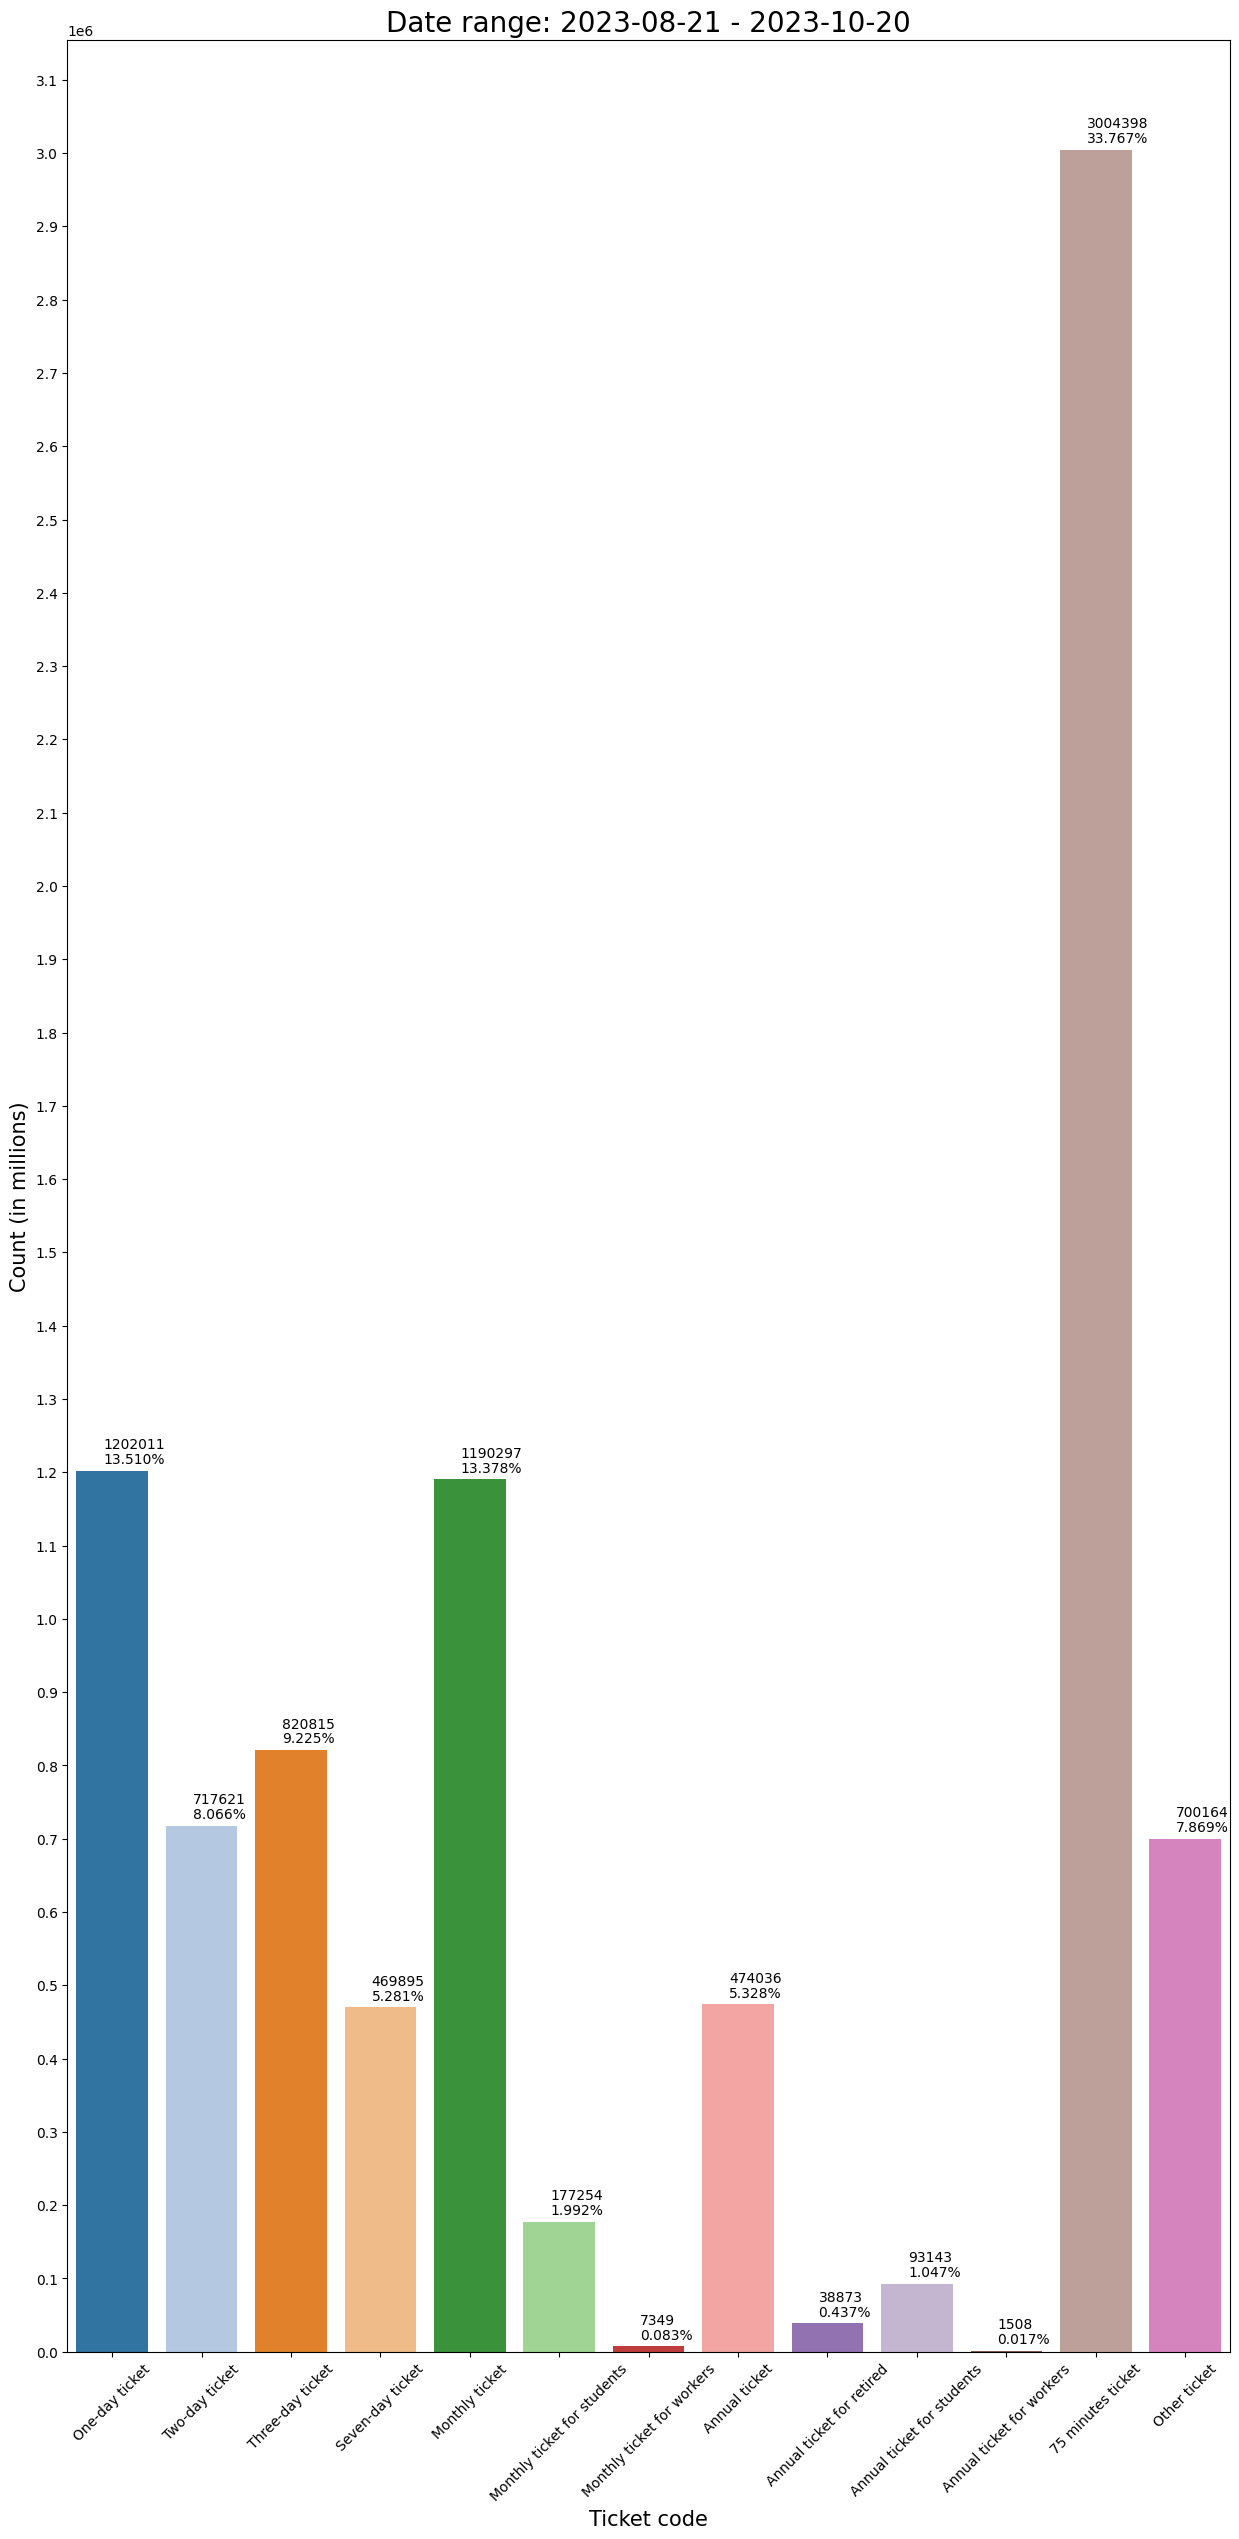

In [234]:
# Countplot of the column 'TICKET_CODE'
fig, ax = plt.subplots(figsize=(15,8))
# Countplot of the column 'TICKET_CODE'
sns.countplot(x='TICKET_CODE', data=df, order=df['TICKET_CODE'].value_counts().sort_index().index)
# The title of the plot is the date range of the dataset
plt.title('Date range: ' + str(df['DATA'].min().to_pydatetime().date()) + ' - ' + str(df['DATA'].max().to_pydatetime().date()), fontsize=20)
plt.xlabel('Ticket code', fontsize=15)
plt.ylabel('Count (in millions)', fontsize=15)

# Change yticks to have a better visualization
scale = np.arange(0, max(df['TICKET_CODE'].value_counts())+100000, 100000)
plt.yticks(scale)

# Add the percentage of each category on top of the bars
for p in ax.patches:
    ax.annotate('{:.3f}%'.format(100*p.get_height()/len(df)), (p.get_x()+0.3, p.get_height()+10000))

# Add the count of each category on top of the bars
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()+30000))

# As xticks use the name of the ticket profile using the dictionary 'dict_tickets' only if the number of unique values of the column 'TICKET_CODE' is more than 0
if df['TICKET_CODE'].nunique() > 0:
    plt.xticks(ticks=range(len(df['TICKET_CODE'].value_counts())), labels=df['TICKET_CODE'].value_counts().sort_index().rename(dict_tickets).index, rotation=45, fontsize=10)

# Add a legend for x-ticks and their description in the dictionary 'dict_tickets', for each ticket profile code
# plt.legend(labels=df['TICKET_CODE'].value_counts().sort_index().rename(dict_tickets).index, loc='center left', bbox_to_anchor=(1, 0, 0.5, 1), fontsize=15)

# Add a padding on the top of the plot
plt.subplots_adjust(top=3)

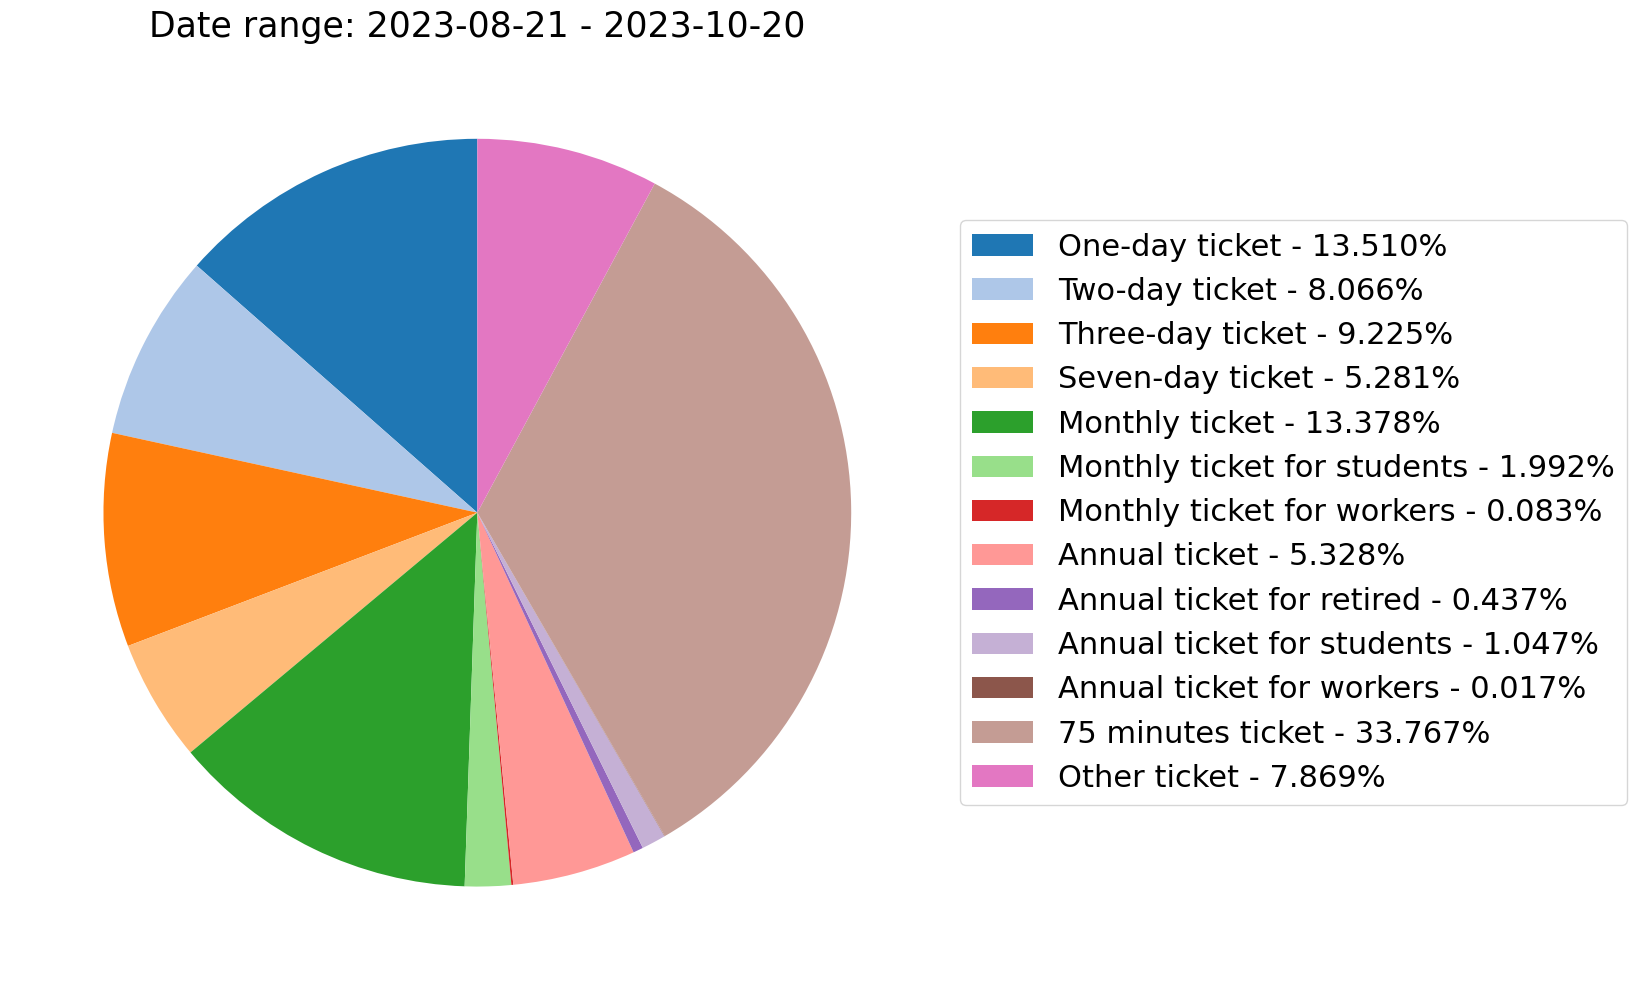

In [235]:
# Plot a pie chart of the column 'TICKET_CODE'
fig, ax = plt.subplots(figsize=(20,10))
# Change palette to have more more colors
sns.set_palette("tab20")
df['TICKET_CODE'].value_counts().sort_index().plot.pie(startangle=90)

plt.title('Date range: ' + str(df['DATA'].min().to_pydatetime().date()) + ' - ' + str(df['DATA'].max().to_pydatetime().date()), fontsize=25)
plt.ylabel('')

# Modify the legend to have the description of the ticket profile and the percentage of each category appended
handles, labels = ax.get_legend_handles_labels()
labels = [s + ' - {:.3f}%'.format(100*v/len(df)) for s, v in zip(df['TICKET_CODE'].value_counts().sort_index().rename(dict_tickets).index, df['TICKET_CODE'].value_counts().sort_index())]
ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0, 0.5, 1), fontsize=22)

# Ensure that the labels are not overlapped on the pie chart
plt.tight_layout()

# Remove the labels on the pie chart
texts = [text for text in ax.texts]
for text in texts:
    text.set_visible(False)

fig.patch.set_facecolor('white')
plt.show()

In [236]:
# Print the number of tickets for each ticket profile code ordered by the code of the ticket profile; print the name of the ticket profile using the dictionary 'dict_tickets'
df['TICKET_CODE'].value_counts().sort_index().rename(dict_tickets).reindex(dict_tickets.values(), fill_value=0)


TICKET_CODE
One-day ticket                 1202011
Two-day ticket                  717621
Three-day ticket                820815
Seven-day ticket                469895
Monthly ticket                 1190297
Monthly ticket for students     177254
Monthly ticket for retired           0
Monthly ticket for workers        7349
Annual ticket                   474036
Annual ticket for students       93143
Annual ticket for retired        38873
Annual ticket for workers         1508
75 minutes ticket              3004398
Other ticket                    700164
Name: count, dtype: int64

#### Delete the validation that are with TICKET_CODE = 8 (other tickets) 

In [237]:
shape_before = df.shape[0]

# Delete 8 tickets because they are not useful for the analysis 
df = df[df['TICKET_CODE'] != '8']

# Print the number of rows before and after the deletion of the 8 tickets and the difference
print('The number of rows before the deletion of the 8 tickets is: {}'.format(shape_before))
print('The number of rows after the deletion of the 8 tickets is: {}'.format(df.shape[0]))
print('The difference is: {}'.format(shape_before - df.shape[0]))

The number of rows before the deletion of the 8 tickets is: 8897364
The number of rows after the deletion of the 8 tickets is: 8197200
The difference is: 700164


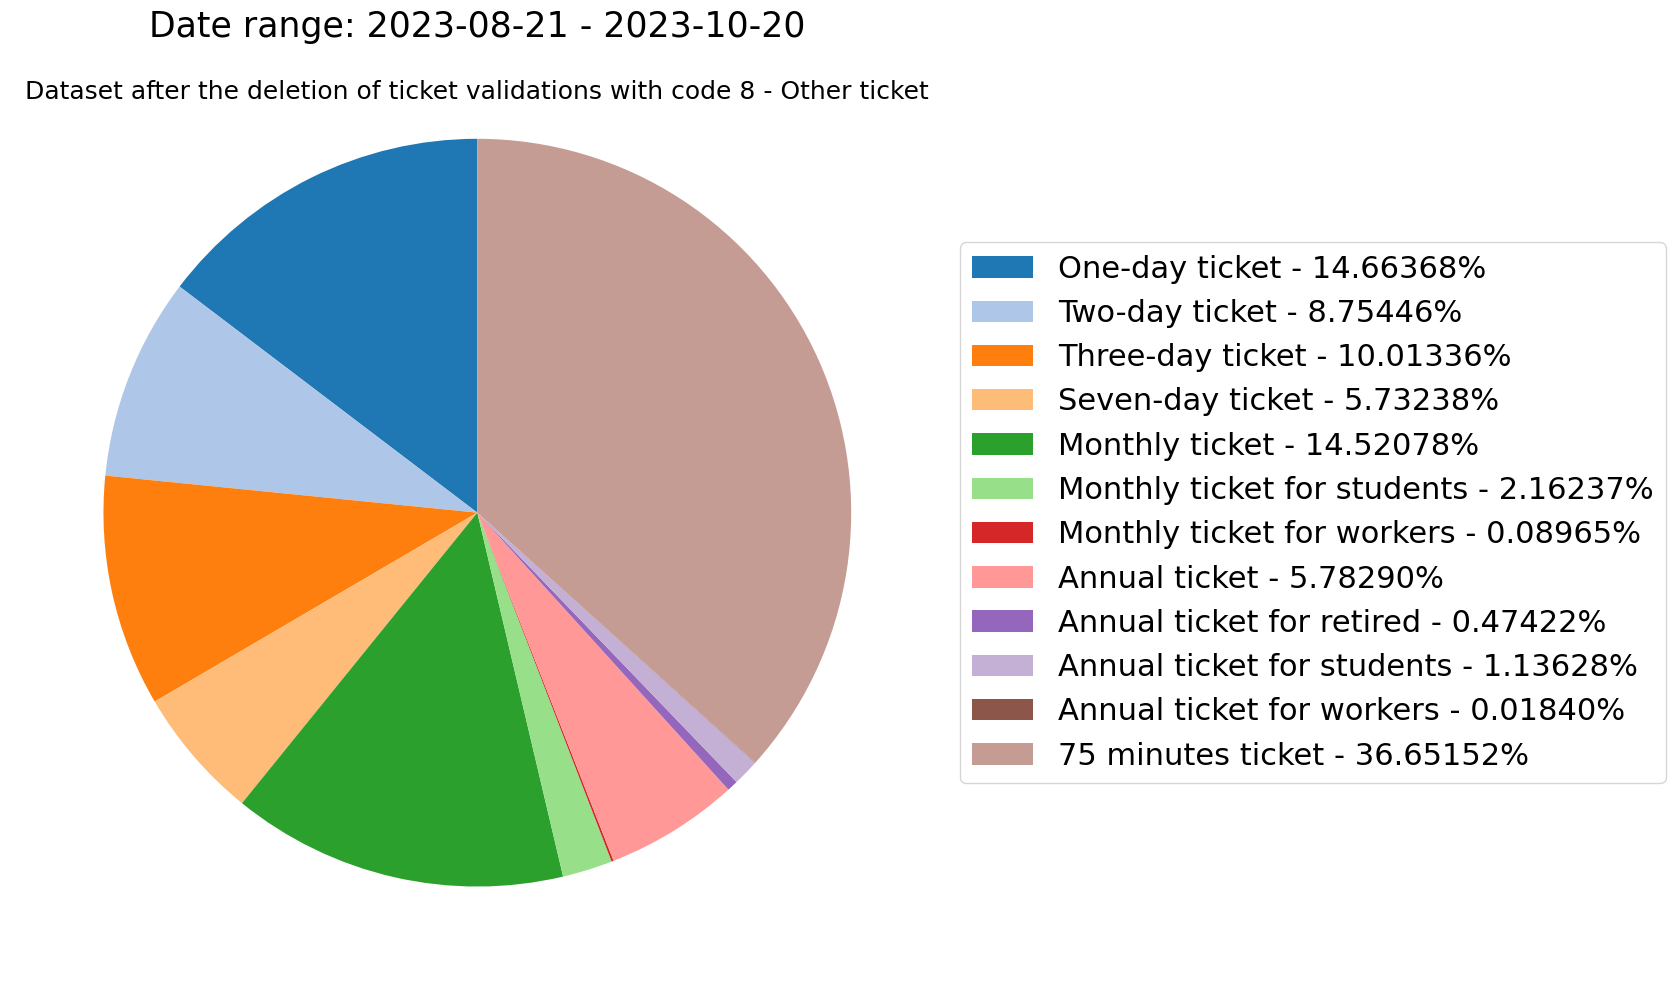

In [238]:
# Plot a pie chart of the column 'TICKET_CODE'
fig, ax = plt.subplots(figsize=(20,10))
# Change palette to have more more colors
sns.set_palette("tab20")
df['TICKET_CODE'].value_counts().sort_index().plot.pie(startangle=90)

plt.title('Date range: ' + str(df['DATA'].min().to_pydatetime().date()) + ' - ' + str(df['DATA'].max().to_pydatetime().date()), fontsize=25)
plt.ylabel('')

# Modify the legend to have the description of the ticket profile and the percentage of each category appended
handles, labels = ax.get_legend_handles_labels()
labels = [s + ' - {:.5f}%'.format(100*v/len(df)) for s, v in zip(df['TICKET_CODE'].value_counts().sort_index().rename(dict_tickets).index, df['TICKET_CODE'].value_counts().sort_index())]
ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0, 0.5, 1), fontsize=22)

# Ensure that the labels are not overlapped on the pie chart
plt.tight_layout()

# Remove the labels on the pie chart
texts = [text for text in ax.texts]
for text in texts:
    text.set_visible(False)

# Add a text that informs that is the dataset after the deletion of ticket validations with code 8 - Other ticket
plt.text(0.5, 0.95, 'Dataset after the deletion of ticket validations with code 8 - Other ticket', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=18)

fig.patch.set_facecolor('white')
plt.show()

In [239]:
# Print the number of rows for each ticket profile code ordered by the code of the ticket profile; print the name of the ticket profile using the dictionary 'dict_tickets'
print("The number of rows for each ticket profile code ordered by the code of the ticket profile, with a reference to the name of the serial number, is: ")
for i in range(1, 8):
    print("The number of rows for the ticket profile code {} ({}) is: {}".format(i, dict_tickets[str(i)], df[df['TICKET_CODE'] == str(i)].shape[0]))

The number of rows for each ticket profile code ordered by the code of the ticket profile, with a reference to the name of the serial number, is: 
The number of rows for the ticket profile code 1 (One-day ticket) is: 1202011
The number of rows for the ticket profile code 2 (Two-day ticket) is: 717621
The number of rows for the ticket profile code 3 (Three-day ticket) is: 820815
The number of rows for the ticket profile code 4 (Seven-day ticket) is: 469895
The number of rows for the ticket profile code 5 (Monthly ticket) is: 1190297
The number of rows for the ticket profile code 6 (Annual ticket) is: 474036
The number of rows for the ticket profile code 7 (75 minutes ticket) is: 3004398


In [240]:
# Total number of tickets
print("The total number of tickets is: ", df.shape[0])

The total number of tickets is:  8197200


## Subdivision of dataset


In [241]:
if file_name == "esportazionePasqua23":
    # It is necessary to divide the dataset into 2 parts:
    # First part: from 2023-04-04 to 2023-05-03 (that contains the Easter period, Liberation Day and Labour Day)
    # Second part: from 2023-05-04 to 2023-06-03 (that contains the Republic Day)

    # First part
    df_1 = df[df['DATA'] <= '2023-05-03']
    # Export the first part
    df_1.to_csv('data/processed/ticketCode_' + file_name + '_part1.txt', sep='\t', index=False)
    print("First part exported successfully to 'data/processed/ticketCode_" + file_name + "_part1.txt'")
    # Print the number of rows
    print("The number of rows of the first part is: ", df_1.shape[0])
    
    # Second part
    df_2 = df[df['DATA'] > '2023-05-03']
    # Export the second part
    df_2.to_csv('data/processed/ticketCode_' + file_name + '_part2.txt', sep='\t', index=False)
    print("Second part exported successfully to 'data/processed/ticketCode_" + file_name + "_part2.txt'")
    # Print the number of rows
    print("The number of rows of the second part is: ", df_2.shape[0])

In [242]:
if file_name == "esportazionePasqua23":
    # Ask which part the user wants to clean
    while True:
        print("The first part is from 2023-04-04 to 2023-05-03 (that contains the Easter period, Liberation Day and Labour Day)")
        print("The second part is from 2023-05-04 to 2023-06-03 (that contains the Republic Day)")

        input_part = input("Which part do you want to clean? (1 or 2) ")
        if input_part == "1":
            df = df_1
            file_name = "esportazionePasqua23_part1"
            break
        elif input_part == "2":
            df = df_2
            file_name = "esportazionePasqua23_part2"
            break
        else:
            print("Please, insert a valid input (1 or 2)")
            continue

In [243]:
if file_name == "esportazioneFineAgosto2023":
    # It is necessary to divide the dataset into 2 parts:
    # First part: from from 21 August 2023 to 20 September 2023 (that contains Venice Film Festival)
    # Second part: from from 21 September 2023 to 20 October 2023

    # First part
    df_1 = df[df['DATA'] <= '2023-09-20']
    # Export the first part
    df_1.to_csv('data/processed/ticketCode_' + file_name + '_part1.txt', sep='\t', index=False)
    print("First part exported successfully to 'data/processed/ticketCode_" + file_name + "_part1.txt'")
    # Print the number of rows
    print("The number of rows of the first part is: ", df_1.shape[0])
    
    # Second part
    df_2 = df[df['DATA'] > '2023-09-20']
    # Export the second part
    df_2.to_csv('data/processed/ticketCode_' + file_name + '_part2.txt', sep='\t', index=False)
    print("Second part exported successfully to 'data/processed/ticketCode_" + file_name + "_part2.txt'")
    # Print the number of rows
    print("The number of rows of the second part is: ", df_2.shape[0])

First part exported successfully to 'data/processed/ticketCode_esportazioneFineAgosto2023_part1.txt'
The number of rows of the first part is:  4301247
Second part exported successfully to 'data/processed/ticketCode_esportazioneFineAgosto2023_part2.txt'
The number of rows of the second part is:  3895953


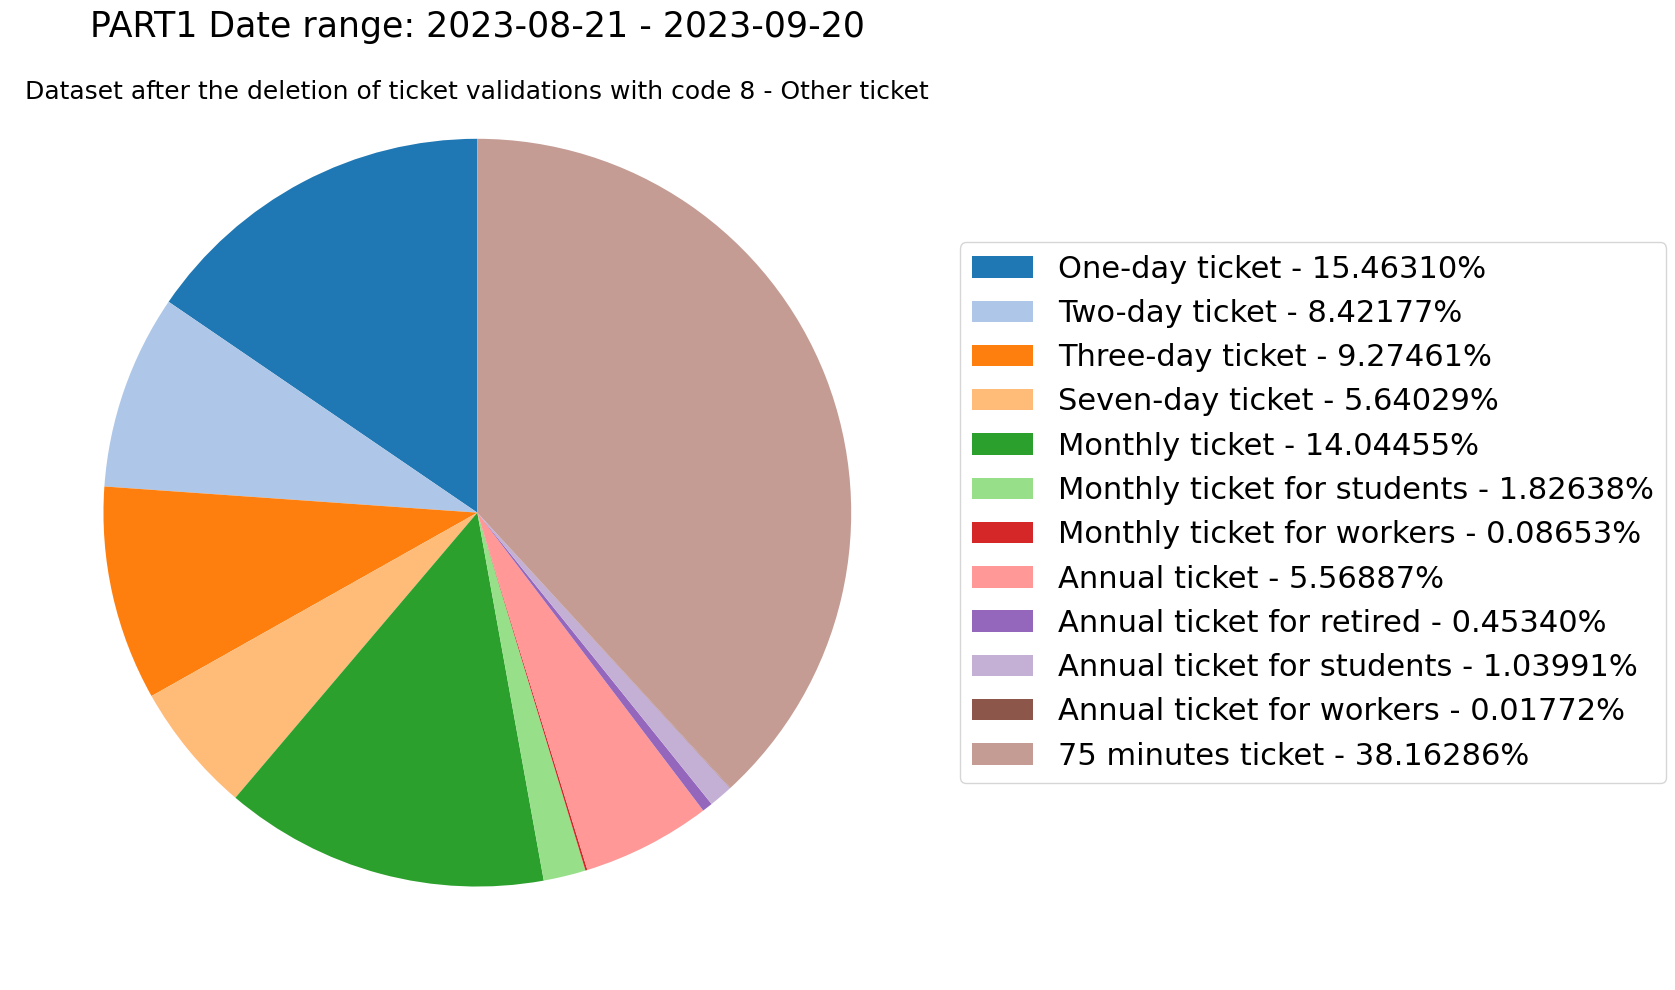

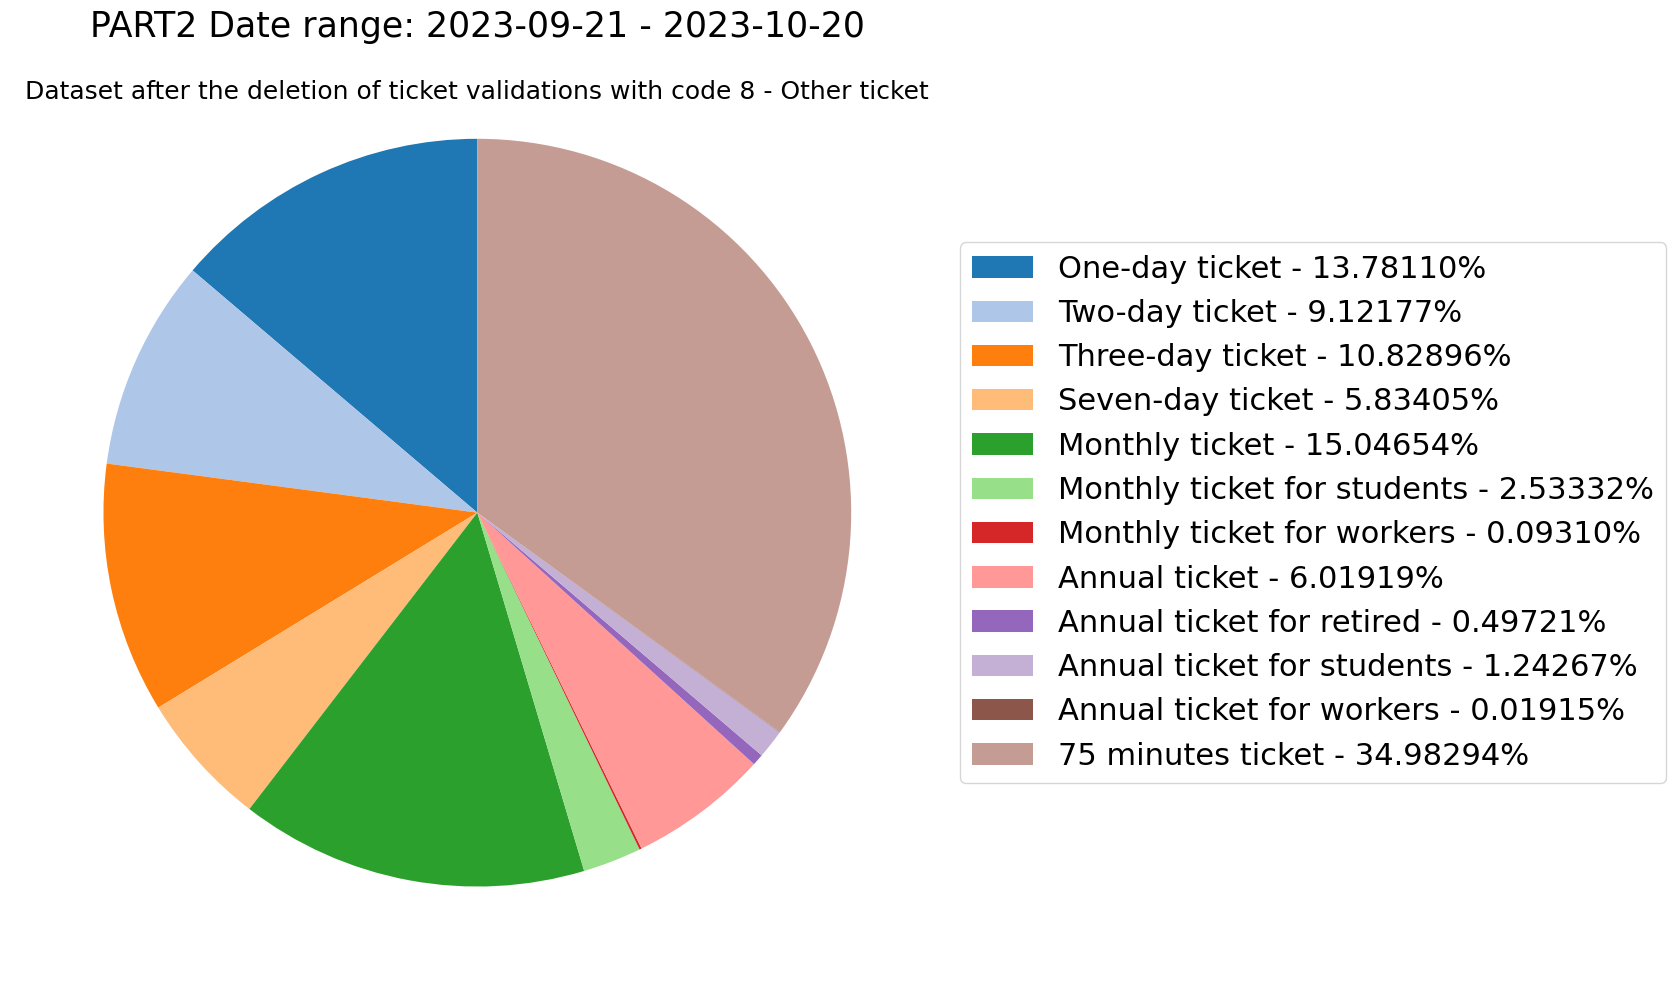

In [245]:
if file_name == "esportazioneFineAgosto2023":
    # Plot a pie chart of the column 'TICKET_CODE'
    # Plot a pie chart of the column 'TICKET_CODE'
    fig, ax = plt.subplots(figsize=(20,10))
    # Change palette to have more more colors
    sns.set_palette("tab20")
    df_1['TICKET_CODE'].value_counts().sort_index().plot.pie(startangle=90)

    plt.title('PART1 Date range: ' + str(df_1['DATA'].min().to_pydatetime().date()) + ' - ' + str(df_1['DATA'].max().to_pydatetime().date()), fontsize=25)
    plt.ylabel('')

    # Modify the legend to have the description of the ticket profile and the percentage of each category appended
    handles, labels = ax.get_legend_handles_labels()
    labels = [s + ' - {:.5f}%'.format(100*v/len(df_1)) for s, v in zip(df_1['TICKET_CODE'].value_counts().sort_index().rename(dict_tickets).index, df_1['TICKET_CODE'].value_counts().sort_index())]
    ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0, 0.5, 1), fontsize=22)

    # Ensure that the labels are not overlapped on the pie chart
    plt.tight_layout()

    # Remove the labels on the pie chart
    texts = [text for text in ax.texts]
    for text in texts:
        text.set_visible(False)

    # Add a text that informs that is the dataset after the deletion of ticket validations with code 8 - Other ticket
    plt.text(0.5, 0.95, 'Dataset after the deletion of ticket validations with code 8 - Other ticket', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=18)

    fig.patch.set_facecolor('white')
    plt.show()

    

    # Plot a pie chart of the column 'TICKET_CODE'
    # Plot a pie chart of the column 'TICKET_CODE'
    fig, ax = plt.subplots(figsize=(20,10))
    # Change palette to have more more colors
    sns.set_palette("tab20")
    df_2['TICKET_CODE'].value_counts().sort_index().plot.pie(startangle=90)

    plt.title('PART2 Date range: ' + str(df_2['DATA'].min().to_pydatetime().date()) + ' - ' + str(df_2['DATA'].max().to_pydatetime().date()), fontsize=25)
    plt.ylabel('')

    # Modify the legend to have the description of the ticket profile and the percentage of each category appended
    handles, labels = ax.get_legend_handles_labels()
    labels = [s + ' - {:.5f}%'.format(100*v/len(df_2)) for s, v in zip(df_2['TICKET_CODE'].value_counts().sort_index().rename(dict_tickets).index, df_2['TICKET_CODE'].value_counts().sort_index())]
    ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0, 0.5, 1), fontsize=22)

    # Ensure that the labels are not overlapped on the pie chart
    plt.tight_layout()

    # Remove the labels on the pie chart
    texts = [text for text in ax.texts]
    for text in texts:
        text.set_visible(False)

    # Add a text that informs that is the dataset after the deletion of ticket validations with code 8 - Other ticket
    plt.text(0.5, 0.95, 'Dataset after the deletion of ticket validations with code 8 - Other ticket', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=18)

    fig.patch.set_facecolor('white')
    plt.show()

In [246]:
if file_name == "esportazioneFineAgosto2023":
    # Ask which part the user wants to clean
    while True:
        print("The first part is from 21 August 2023 to 20 September 2023 (that contains Venice Film Festival)")
        print("The second part is from 21 September 2023 to 20 October 2023")

        input_part = input("Which part do you want to clean? (1 or 2) ")
        if input_part == "1":
            df = df_1
            file_name = "esportazioneFineAgosto2023_part1"
            break
        elif input_part == "2":
            df = df_2
            file_name = "esportazioneFineAgosto2023_part2"
            break
        else:
            print("Please, insert a valid input (1 or 2)")
            continue

The first part is from 21 August 2023 to 20 September 2023 (that contains Venice Film Festival)
The second part is from 21 September 2023 to 20 October 2023


## Data Cleaning

### Useless stamps

In [247]:
# take the first 200000 rows
# df = df.head(2000)

In [248]:
# Reset the index of the df and drop the old index in order to have a new index starting from 0 to the number of rows
# It is necessary to have a new index because the groupby function has created a multi-index
df.reset_index(drop=True, inplace=True)

In [ ]:
# Create a new column 'MIN_TEMPORAL_GAP' that contains the minimum temporal gap between two validations for the same serial and fermata in minutes
df = df.groupby(['SERIALE','DATA', 'DESCRIZIONE']).apply(lambda x: x.assign(MIN_TEMPORAL_GAP = x['DATA_VALIDAZIONE'].diff().dt.total_seconds()/60))

In [ ]:
df.head(20)

In [ ]:
df.tail(20)

In [ ]:
df['MIN_TEMPORAL_GAP'].value_counts()

In [ ]:
# How many rows have a minimum temporal gap equal to NaN?
df[df['MIN_TEMPORAL_GAP'].isna()].shape[0]

In [ ]:
# Prepare a file to save the information about the results of the cleaning process
# File txt with name: "cleaningResults + filename + date.txt"
import datetime
date = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
with open('data/processed/cleaningResults_' + file_name + '_' + date + '.txt', 'w') as f:
    f.write('File name: ' + file_name + '\n')
    f.write('Operation starts at: ' + date + '\n')

In [ ]:
# Cleaning operation: remove the rows using the minimum temporal gap

# Find a reasonable delta of MIN_TEMPORAL_GAP to remove the rows that have a minimum temporal gap for the same serial and fermata less than this delta
with open('data/processed/cleaningResults_' + file_name + '_' + date + '.txt', 'a') as f:
    # Print the minimum value of the column MIN_TEMPORAL_GAP
    print('The minimum value of the column MIN_TEMPORAL_GAP is: {}'.format(df['MIN_TEMPORAL_GAP'].min()))
    f.write('The minimum value of the column MIN_TEMPORAL_GAP is: {}\n'.format(df['MIN_TEMPORAL_GAP'].min()))

    # Print the maximum value of the column MIN_TEMPORAL_GAP
    print('The maximum value of the column MIN_TEMPORAL_GAP is: {}'.format(df['MIN_TEMPORAL_GAP'].max()))
    f.write('The maximum value of the column MIN_TEMPORAL_GAP is: {}\n'.format(df['MIN_TEMPORAL_GAP'].max()))

    # Print the mean value of the column MIN_TEMPORAL_GAP
    print('The mean value of the column MIN_TEMPORAL_GAP is: {}'.format(df['MIN_TEMPORAL_GAP'].mean()))
    f.write('The mean value of the column MIN_TEMPORAL_GAP is: {}\n'.format(df['MIN_TEMPORAL_GAP'].mean()))

    # Print the median value of the column MIN_TEMPORAL_GAP
    print('The median value of the column MIN_TEMPORAL_GAP is: {}'.format(df['MIN_TEMPORAL_GAP'].median()))
    f.write('The median value of the column MIN_TEMPORAL_GAP is: {}\n'.format(df['MIN_TEMPORAL_GAP'].median()))

    # Print the standard deviation of the column MIN_TEMPORAL_GAP
    print('The standard deviation of the column MIN_TEMPORAL_GAP is: {}'.format(df['MIN_TEMPORAL_GAP'].std()))
    f.write('The standard deviation of the column MIN_TEMPORAL_GAP is: {}\n'.format(df['MIN_TEMPORAL_GAP'].std()))

    # Print the 0.05th percentile of the column MIN_TEMPORAL_GAP
    print('The 0.05th percentile of the column MIN_TEMPORAL_GAP is: {}'.format(df['MIN_TEMPORAL_GAP'].quantile(0.05)))
    f.write('The 0.05th percentile of the column MIN_TEMPORAL_GAP is: {}\n'.format(df['MIN_TEMPORAL_GAP'].quantile(0.05)))

    # Print the 0.10th percentile of the column MIN_TEMPORAL_GAP
    print('The 0.10th percentile of the column MIN_TEMPORAL_GAP is: {}'.format(df['MIN_TEMPORAL_GAP'].quantile(0.10)))
    f.write('The 0.10th percentile of the column MIN_TEMPORAL_GAP is: {}\n'.format(df['MIN_TEMPORAL_GAP'].quantile(0.10)))

    # Print the 25th percentile of the column MIN_TEMPORAL_GAP
    print('The 25th percentile of the column MIN_TEMPORAL_GAP is: {}'.format(df['MIN_TEMPORAL_GAP'].quantile(0.25)))
    f.write('The 25th percentile of the column MIN_TEMPORAL_GAP is: {}\n'.format(df['MIN_TEMPORAL_GAP'].quantile(0.25)))

    # Print the 75th percentile of the column MIN_TEMPORAL_GAP
    print('The 75th percentile of the column MIN_TEMPORAL_GAP is: {}'.format(df['MIN_TEMPORAL_GAP'].quantile(0.75)))
    f.write('The 75th percentile of the column MIN_TEMPORAL_GAP is: {}\n'.format(df['MIN_TEMPORAL_GAP'].quantile(0.75)))

    # Print the 90th percentile of the column MIN_TEMPORAL_GAP
    print('The 90th percentile of the column MIN_TEMPORAL_GAP is: {}'.format(df['MIN_TEMPORAL_GAP'].quantile(0.90)))
    f.write('The 90th percentile of the column MIN_TEMPORAL_GAP is: {}\n'.format(df['MIN_TEMPORAL_GAP'].quantile(0.90)))

    # Print the 95th percentile of the column MIN_TEMPORAL_GAP
    print('The 95th percentile of the column MIN_TEMPORAL_GAP is: {}'.format(df['MIN_TEMPORAL_GAP'].quantile(0.95)))
    f.write('The 95th percentile of the column MIN_TEMPORAL_GAP is: {}\n'.format(df['MIN_TEMPORAL_GAP'].quantile(0.95)))

    # Print the 99th percentile of the column MIN_TEMPORAL_GAP
    print('The 99th percentile of the column MIN_TEMPORAL_GAP is: {}'.format(df['MIN_TEMPORAL_GAP'].quantile(0.99)))
    f.write('The 99th percentile of the column MIN_TEMPORAL_GAP is: {}\n'.format(df['MIN_TEMPORAL_GAP'].quantile(0.99)))

    # Print the 99.9th percentile of the column MIN_TEMPORAL_GAP
    print('The 99.9th percentile of the column MIN_TEMPORAL_GAP is: {}'.format(df['MIN_TEMPORAL_GAP'].quantile(0.999)))
    f.write('The 99.9th percentile of the column MIN_TEMPORAL_GAP is: {}\n'.format(df['MIN_TEMPORAL_GAP'].quantile(0.999)))

    # Decide the delta of MIN_TEMPORAL_GAP to remove the rows that have a minimum temporal gap for the same serial and fermata less than this delta
    delta = df['MIN_TEMPORAL_GAP'].quantile(0.1)
    if delta == 0:
        delta = df['MIN_TEMPORAL_GAP'].quantile(0.25)
    if delta == 0:
        delta = df['MIN_TEMPORAL_GAP'].median()
    # # If the delta is greater than 5, set it to 5; it is an euristic value that I have chosen to avoid to remove too many rows
    # # 5 minutes because I can consider that in 5 minutes the public transport vehicle has already arrived at a stop where a person can take another public transport vehicle
    # if delta >= 5:
    #     delta = 5
    print('The delta of MIN_TEMPORAL_GAP is: {}'.format(delta))
    f.write('The delta of MIN_TEMPORAL_GAP is: {}\n'.format(delta))

In [ ]:
# Cleaning operation: remove the rows using the minimum temporal gap

# Save the number of rows before the cleaning operation
shape_before = df.shape[0]

# Delete the rows that have a minimum temporal gap for the same serial and fermata more than the delta calculated before.
# Do not remove the rows with NaN values because they are the first validations of the day of a specific serial and fermata usefull for the analysis
df = df[(df['MIN_TEMPORAL_GAP'] > delta) | (df['MIN_TEMPORAL_GAP'].isna())]

with open('data/processed/cleaningResults_' + file_name + '_' + date + '.txt', 'a') as f:
    # Print the number of rows before and after the cleaning operation and the difference
    print('The number of rows before the cleaning operation is: {}'.format(shape_before))
    f.write('The number of rows before the cleaning operation is: {}\n'.format(shape_before))
    print('The number of rows after the cleaning operation is: {}'.format(df.shape[0]))
    f.write('The number of rows after the cleaning operation is: {}\n'.format(df.shape[0]))
    print('The difference is: {}'.format(shape_before - df.shape[0]))
    f.write('The difference is: {}\n'.format(shape_before - df.shape[0]))

    # Calculate the percentage of rows that has just been deleted
    print('The percentage of rows that has just been deleted is: {}%'.format(round((shape_before - df.shape[0])/shape_before*100, 2)))
    f.write('The percentage of rows that has just been deleted is: {}%\n'.format(round((shape_before - df.shape[0])/shape_before*100, 2)))

In [ ]:
# Delete the column MIN_TEMPORAL_GAP because it is not useful anymore
df.drop('MIN_TEMPORAL_GAP', axis=1, inplace=True)

In [ ]:
# Create a new dataframe, copied from the original one
df_new = df.copy() 

# Print the head of the new dataframe
print(df_new.head())

# Export the new dataframe in a txt file
# The name of the file is dataset_cleaned followed by the name (file_name variable) of the file that has been cleaned with txt extension
name_file = 'dataset_cleaned_temp_' + file_name.split('.')[0] + '.txt'
df_new.to_csv('data/processed/' + name_file, sep='\t', index=False)

print('The script has finished')
with open('data/processed/cleaningResults_' + file_name + '_' + date + '.txt', 'a') as f:
    f.write('The script has finished\n')
    f.write('The name of the file is: ' + name_file + '\n')
    date = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    f.write('Operation completed at: ' + date + '\n')

In [ ]:
# data exported to
print('The data has been exported to: data/processed/' + name_file)